#### **PREDICCIÓN DEL RENDIMIENTO A MEDIO PLAZO PARA SELECCIÓN DE ACTIVOS FINANCIEROS CON MÉTODOS CLÁSICOS Y LSTM**


Este notebook tiene como objetivo desarrollar un sistema de análisis y predicción del rendimiento de acciones a medio y largo plazo, mediante técnicas de aprendizaje automático.
Se parte de un conjunto de datos históricos de mercado con múltiples variables técnicas y temporales, sobre el que se realiza un análisis exploratorio, limpieza y generación de características relevantes.
Posteriormente, se aplican modelos como Naive Bayes, SVM y LSTM para clasificar activos con alta probabilidad de obtener una rentabilidad superior al +10% en los próximos meses, con el fin de construir una cartera de inversión inteligente basada en decisiones automatizadas.

#### **1.LIBRERÍAS**

In [1]:
!pip install pandas adlfs pyarrow

#### **2.IMPORTS**

In [2]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import plotly.express as px
import joblib
from datetime import timedelta
from typing import List, Tuple, Dict,Optional

# Azure
from adlfs import AzureBlobFileSystem

# Models
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc ,  precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif


#### **3.FUNCIONES**

In [3]:
def extract_basic_info(df: pd.DataFrame,are_all_symbols: bool=True)-> None:
    """
    Prints basic information like the number of null values, the shape of the dataframe or the date ranges.
    Args:
        - df (pd.DataFrame): input dataframe
        - are_all_symbols (bool): False to print the variables 'symbol' and 'date'
    Returns:
        - None
    """
    # Basic dataset info
    print("Shape:", df.shape)
    if are_all_symbols:
        print("Symbols:", df['symbol'].nunique())
        print("Date range:", df['date'].min(), "→", df['date'].max())

    # Calculate and show sorted null counts
    null_counts = df.isnull().sum()
    null_counts_sorted = null_counts[null_counts > 0].sort_values(ascending=False)

    print("\nMissing values (sorted):")
    print(null_counts_sorted)

    # Extract ordered list of columns with missing values
    cols_with_nans_sorted = null_counts_sorted.index.tolist()
    print("\nColumns with missing values (sorted):")
    print(cols_with_nans_sorted)
    return None

In [4]:

def load_data_from_dl(account_name: str,container_name: str,relative_path: str,access_key: str)->pd.DataFrame:
    """
    Loads all Parquet files from an Azure Blob Storage path into a single DataFrame.
    Args:
        - account_name (str): Azure Storage account name.
        - container_name (str): Name of the container.
        - relative_path (str): Path inside the container to search for .parquet files.
        - access_key (str): Storage account access key.
    Returns:
        - df (pd.DataFrame): Combined DataFrame from all found Parquet files.
    Raises:
        - ValueError: If no Parquet files are found in the path.
    """
    abfs = AzureBlobFileSystem(account_name=account_name, account_key=access_key)
    

    all_files = abfs.glob(f"{container_name}/{relative_path}/*.parquet")
    print(f"folder: {all_files}")

    if not all_files:
        raise ValueError("Not found .parquet files")

    dfs = []
    for f in all_files:
        print(f"Reading files: {f}")
        with abfs.open(f, "rb") as fp:
            dfs.append(pd.read_parquet(fp))

    df = pd.concat(dfs, ignore_index=True)
    print(df.head())
    return df


In [5]:
def plot_target_distribution(df: pd.DataFrame, target_column: str, label: str="+10%")->None:
    """
    Plots the class distribution of a binary target column.
    Args:
        - df (pd.DataFrame): DataFrame containing the target column
        - target_column (str): Name of the binary column to analyze (e.g., 'target_3m')
        - label (str): Description of the target condition to include in the plot title
    Returns:
        - None
    """
    # Count the values (0 = No, 1 = Yes), sorted by class
    counts = df[target_column].value_counts().sort_index()
    
    # Create the bar plot
    plt.bar(["No", "Yes"], counts.values, color=["red", "green"])
    plt.title(f"Class distribution: {label} in {target_column}")
    plt.ylabel("Number of records")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()
    return None

In [6]:
def plot_close_price(df: pd.DataFrame, symbol:str)->None:
    """
    Plots the close_v price over time for a given stock symbol.
    Args:
       - df (pd.DataFrame): DataFrame containing at least 'symbol', 'date', and 'close_v'
       - symbol (str): Stock symbol to filter and plot
    Returns:
       - None
    """
    data = df[df["symbol"] == symbol].sort_values("date")

    plt.figure(figsize=(12, 4))
    plt.plot(data["date"], data["close_v"])
    plt.title(f"close_v - {symbol}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return None

In [7]:
def plot_correlation_heatmap(df:pd.DataFrame, columns: List[str] )-> None:
    """
    Plots a correlation heatmap using matplotlib for the given columns.
    Args:
       - df (pd.DataFrame): DataFrame containing the data
       - columns (list): List of column names to include in the correlation matrix
    Returns:
       - None
    """
    corr = df[columns].corr()

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(corr, cmap="coolwarm")
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation=45, ha="left")
    ax.set_yticklabels(columns)

    plt.title("Correlation Matrix", pad=20)
    plt.tight_layout()
    plt.show()
    return None

In [8]:
def prepare_data(
    df, 
    target, 
    scaler_type='standard', 
    drop_cols=['date', 'symbol'], 
    k_best=30
):
    """
    Prepare dataset for ML avoiding data leakage:
    - Extract month, year, dayofweek from date
    - Encode symbol and candle_color
    - Drop original date and symbol
    - Remove other target columns except the current target
    - Scale numeric features
    - Select top k features by f_classif

    Args:
        df (pd.DataFrame): Full dataset including features and targets.
        target (str): Target variable name.
        scaler_type (str): 'standard' or 'minmax'.
        drop_cols (list): Columns to drop (default ['date','symbol']).
        k_best (int): Number of features to select.

    Returns:
        df_final (pd.DataFrame): Processed dataframe with selected features and target.
        scaler (object): Fitted scaler.
        selected_features (list): List of selected feature names.
    """
    df_clean = df.copy()

    # Extract month, year and dayofweek from date
    if 'date' in df_clean.columns:
        dt = pd.to_datetime(df_clean['date'])
        df_clean['month'] = dt.dt.month
        df_clean['year'] = dt.dt.year
        df_clean['dayofweek'] = dt.dt.dayofweek

    # Encode categorical columns symbol and candle_color
    if 'symbol' in df_clean.columns:
        df_clean['symbol_encoded'] = LabelEncoder().fit_transform(df_clean['symbol'])
    if 'candle_color' in df_clean.columns:
        df_clean['candle_color_encoded'] = LabelEncoder().fit_transform(df_clean['candle_color'])

    # Drop original columns
    df_clean = df_clean.drop(columns=drop_cols + ['candle_color'], errors='ignore')

    # Remove other target columns except current target to avoid leakage
    target_cols = ['target_3m', 'target_6m', 'target_1y']
    other_targets = [col for col in target_cols if col != target and col in df_clean.columns]
    df_clean = df_clean.drop(columns=other_targets, errors='ignore')

    # Encode remaining categorical columns if any
    for col in df_clean.select_dtypes(include=['category', 'object']).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col])

    y = df_clean[target]
    X = df_clean.drop(columns=[target])

    # Scale features
    scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Select top k features
    selector = SelectKBest(score_func=f_classif, k=k_best)
    X_selected = selector.fit_transform(X_scaled_df, y)
    selected_features = X_scaled_df.columns[selector.get_support()].tolist()
    X_selected_df = pd.DataFrame(X_selected, columns=selected_features, index=X.index)

    df_final = pd.concat([X_selected_df, y], axis=1)

    return df_final, scaler, selected_features


In [9]:
def model_evaluation(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_prob: pd.Series
) -> Tuple[float, float, float]:
    """
    Evaluates the classification model and plots the metrics
    Args:
        - y_test (pd.Series): True target vals
        - y_pred (pd.Series): Predicted class vals
        - y_prov (pd.Series): Predicted probss for clas 1
    Returns:
        - Tuple[float, float, float]: Accuracy, F1 Score, and ROC AUC.
    """
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    precission = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Confusion Matrix:\n {cm}")
    print(f"Precision: {precission:.4f}")
    print(f"Recall: {recall:.4f}")    

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(5, 4))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, f1, roc,cm,precission,recall



In [10]:
def apply_pca(
    df: pd.DataFrame,
    targets: List[str],
    variance_threshold: float = 0.95
) -> Tuple[pd.DataFrame, PCA]:
    """
    Applies PCA after imputing missing values using the mean strategy.

    Args:
        df (pd.DataFrame): DataFrame with features and targets.
        targets (List[str]): List of target column names.
        variance_threshold (float): Minimum cumulative variance to preserve.

    Returns:
        Tuple[pd.DataFrame, PCA]: PCA-transformed DataFrame with targets and the fitted PCA object.
    """
    feature_cols = [col for col in df.columns if col not in targets]
    X = df[feature_cols]
    y = df[targets]

    # Impute missing values
    X_imputed = SimpleImputer(strategy='mean').fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X_imputed)

    # Create DataFrame with PCA components
    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=pca_columns, index=df.index)
    df_pca = pd.concat([df_pca, y], axis=1)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold:.0%} threshold')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by PCA Components')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_pca, pca

#### **4.DATA PREPARATION**

##### **4.1 CARGA DE FICHEROS**

In [11]:
account_name = "smartwalletjorge"
container_name = "smart-wallet-dl"
relative_path = "smart_wallet/stock_data_parquet"
access_key = "j3maJBXtEZE/pbBxtc5x43v4FXswo267vbptsVvEHyesiqhXuAzeukIBuXrOkau2sjtc6yEXFzr/+AStsEZsBg=="
'''with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

account_name = config['storage']['storage_account_name']
container_name = config['storage']['container_name']
relative_path = config['storage']['relative_path']
access_key = config['storage']['access_key']'''

# Cargar el DataFrame desde Azure
df_full = load_data_from_dl(account_name, container_name, relative_path, access_key)
df_full = df_full.dropna(subset=['ret_next_3m', 'ret_next_6m', 'ret_next_1y'])


folder: ['smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet']
Reading files: smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet
         date  symbol      open_v        high         low     close_v  \
0  2023-07-25  TEL.OL   99.110617   99.423126   98.128441   98.128441   
1  2023-07-25    ACIW   23.270000   23.530001   23.129999   23.420000   
2  2023-07-25     TER  114.730270  117.172184  114.730270  116.368141   
3  2023-07-25    ADCT    1.320000    1.330000    1.218000    1.290000   
4  2023-07-25     TEX   59.353587   59.490459   57.574251   57.769783   

      volume  dividends  stock_splits  capital_gains  ...  candle_color  \
0  1170518.0        0.0           0.0            NaN  ...           red   
1   301500.0        0.0           0.0            NaN  ...         green   
2  1256700.0       

In [12]:
df=load_data_from_dl(account_name,container_name,relative_path,access_key)
df_future = df

folder: ['smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet']
Reading files: smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet
         date  symbol      open_v        high         low     close_v  \
0  2023-07-25  TEL.OL   99.110617   99.423126   98.128441   98.128441   
1  2023-07-25    ACIW   23.270000   23.530001   23.129999   23.420000   
2  2023-07-25     TER  114.730270  117.172184  114.730270  116.368141   
3  2023-07-25    ADCT    1.320000    1.330000    1.218000    1.290000   
4  2023-07-25     TEX   59.353587   59.490459   57.574251   57.769783   

      volume  dividends  stock_splits  capital_gains  ...  candle_color  \
0  1170518.0        0.0           0.0            NaN  ...           red   
1   301500.0        0.0           0.0            NaN  ...         green   
2  1256700.0       

In [16]:
print("Types summary \n:")
print(df.dtypes.value_counts())

Types summary 
:
float64    50
object      3
int32       2
dtype: int64


In [17]:
object_cols = df.select_dtypes(include="object").columns.tolist()
print("Object type columns:", object_cols)

Object type columns: ['date', 'symbol', 'candle_color']


In [13]:
df["date"] = pd.to_datetime(df["date"])
df["symbol"] = df["symbol"].astype("category")
df["candle_color"] = df["candle_color"].astype("category")

In [19]:
df.shape

(11482274, 55)

In [20]:
df['symbol'].nunique()

2728

A la hora de entrenar el algoritmo SVM o LSTM con un 80% de datos de entrenamiento y 20% de datos de test, con los recursos disponibles el entrenamiento se demora demasiado. A continuación comprobamos que el máximo de sesiones son 6494 y que nuestro dataset tiene 2724 empresas únicas. Vamos a tener que tomar una decisión sobre qué accioens mantener.  Si limitamos el rango temporal, no contabilizamos posibles "cisnes negros", eventos que causaron caídas abruptas en las bolsas. Si limitamos por histórico a las empresas que lleven más de 10 años en bolsa, dejamos fuera empresas de reciente creación que pueden ser prometedoras. Nuestro objetivo es poder identificar acciones prometedoras para poder maximizar nuestra rentabilidad como inversores. 

In [21]:
df_symbol_counts = df.groupby("symbol").size().reset_index(name="n_rows").sort_values('n_rows',ascending=False)
df_symbol_counts.head(10)

,symbol,n_rows
1525,MBK.WA,6514
491,CDR.WA,6513
1362,KGH.WA,6513
1885,PEO.WA,6513
1917,PKN.WA,6513
315,BCP.LS,6509
787,EDP.LS,6509
1330,JMT.LS,6508
4,AALB.AS,6507
2160,SBMO.AS,6506


<Axes: >

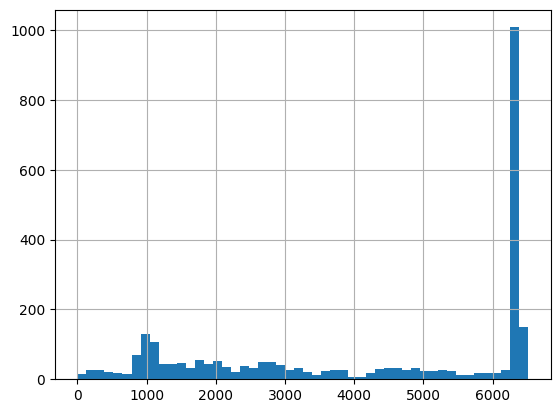

In [22]:
df_symbol_counts = df.groupby("symbol").size().reset_index(name="n_rows")
df_symbol_counts["n_rows"].hist(bins=50)

In [23]:
for threshold in [1000, 1500, 2000, 3000, 4000,5000,6000]:
    n = (df_symbol_counts["n_rows"] >= threshold).sum()
    print(f"At least contains {threshold} sessions: {n} symbols")

At least contains 1000 sessions: 2443 symbols
At least contains 1500 sessions: 2170 symbols
At least contains 2000 sessions: 2001 symbols
At least contains 3000 sessions: 1711 symbols
At least contains 4000 sessions: 1541 symbols
At least contains 5000 sessions: 1357 symbols
At least contains 6000 sessions: 1198 symbols


##### **4.2 CREACIÓN DE LA VARIABLE TARGET**

##### **4.2 CREACIÓN DE LA VARIABLE TARGET**

El propósito de este TFM es tratar de construir una cartera inteligente a medio/largo plazo basada en el comportamiento técnico y estadístico de los activos medidos. Para ello se definirán 3 ventanas temporales distintas que representarán nuestros objetivos de predicción: target_3m, target_6m y target_1y.

En horizontes cortos, como los 3 meses, la evolución del precio puede estar dominada por factores externos, eventos puntuales o ruido de mercado, lo que dificulta que un modelo técnico pueda capturar valores consistentes. A este plazo, la volatilidad tiende a ser más elevada y menso explicable a través del análisis técnico tradicional.

A los 6 meses, los indicadores técnicos y de momentum suelen tener mayor capacidad para anticipar movimientos sostenidos, ya que se reducen los efectos de las oscilaciones a corto plazo. 

Finalmente, a 1 año vista, el enfoque es un poco más estructural. El modelo busca detectar activos con inercia positiva prolongada y fundamentos técnicos más sólidos, que sean capaces de sostener su crecimiento.

Para evitar errores metodológicos, se va a evitar utilizar como variables de entrada aquellas que están directamente impactadas en la construcción del propio objetivo. Es decir, por ejemplo, no se utilizará ret_past_1y para predecir target_1y. 

Por lo tanto, cuando construyamos los algoritmos, se establecerán mecanismos de control para evitar fugas de información y asegurar que el aprendizaje se base exclusivamente en datos disponibles en el momento de la predicción.


In [14]:
df["target_3m"] = (df["ret_next_3m"] > 0.10).astype(int)
df["target_6m"] = (df["ret_next_6m"] > 0.10).astype(int)
df["target_1y"] = (df["ret_next_1y"] > 0.10).astype(int)

La distribución de clases muestra un ligero desbalanceo.

In [19]:
df['target_3m'].value_counts(normalize=True)

0    0.695479
1    0.304521
Name: target_3m, dtype: float64

In [16]:
df['target_6m'].value_counts(normalize=True)

0    0.610098
1    0.389902
Name: target_6m, dtype: float64

In [17]:
df['target_1y'].value_counts(normalize=True)

0    0.54114
1    0.45886
Name: target_1y, dtype: float64

In [18]:
df.shape

(11482274, 56)

##### **4.3 ANÁLISIS DE DATOS EXPLORATORIO**

In [20]:
print(f"max date: {min(df.date)}")
print(f"min date: {max(df.date)}")
print(df.shape)

max date: 2000-01-31 00:00:00
min date: 2025-05-16 00:00:00
(11482274, 56)


In [21]:
df.describe()

,open_v,high,low,close_v,volume,dividends,stock_splits,capital_gains,prev_close,prev_volume,...,var_95,price_lead_3m,price_lead_6m,price_lead_1y,ret_next_3m,ret_next_6m,ret_next_1y,target_3m,target_6m,target_1y
count,1.148155e+07,1.148155e+07,1.148155e+07,1.148155e+07,1.148155e+07,1.145228e+07,1.145228e+07,7348.0,1.148157e+07,1.148157e+07,...,1.148227e+07,1.130989e+07,1.113865e+07,1.079844e+07,1.130417e+07,1.113299e+07,1.079290e+07,1.148227e+07,1.148227e+07,1.148227e+07
mean,1.873613e+06,1.962834e+06,1.763391e+06,1.872133e+06,6.980544e+06,1.754005e-02,2.882228e-04,0.0,1.877734e+06,6.980277e+06,...,-3.504564e-02,1.594010e+06,1.051892e+06,5.383887e+05,4.915334e-02,8.560003e-02,1.831868e-01,3.045207e-01,3.899022e-01,4.588601e-01
std,3.371690e+08,3.511776e+08,3.168303e+08,3.364750e+08,1.255615e+08,5.918824e+00,3.408135e-02,0.0,3.370065e+08,1.255593e+08,...,2.331396e-02,3.123051e+08,1.979356e+08,1.032327e+08,9.869676e+00,1.199445e+00,3.062883e+00,4.602041e-01,4.877279e-01,4.983047e-01
min,-7.560517e+06,-7.748446e+06,-7.517148e+06,-7.653034e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-7.653034e+06,0.000000e+00,...,-6.666666e-01,-7.653034e+06,-7.653034e+06,-7.350904e+06,-1.001415e+01,-9.381862e+00,-2.293004e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.416559e+00,9.590000e+00,9.237314e+00,9.415393e+00,7.830000e+04,0.000000e+00,0.000000e+00,0.0,9.414204e+00,7.820000e+04,...,-4.272256e-02,9.470832e+00,9.532314e+00,9.680000e+00,-8.022194e-02,-1.027382e-01,-1.300511e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.027668e+01,2.060302e+01,1.994536e+01,2.027544e+01,3.761000e+05,0.000000e+00,0.000000e+00,0.0,2.027094e+01,3.759000e+05,...,-2.867384e-02,2.043045e+01,2.059594e+01,2.094144e+01,2.389442e-02,4.670116e-02,9.046793e-02,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.770042e+01,4.839059e+01,4.698257e+01,4.769579e+01,1.562100e+06,0.000000e+00,0.000000e+00,0.0,4.768000e+01,1.561800e+06,...,-2.027472e-02,4.812000e+01,4.857846e+01,4.950203e+01,1.299001e-01,2.012249e-01,3.276056e-01,1.000000e+00,1.000000e+00,1.000000e+00
max,1.356750e+11,1.370250e+11,1.275750e+11,1.363500e+11,1.145623e+10,9.403261e+03,5.000000e+01,0.0,1.363500e+11,1.145623e+10,...,5.048864e-03,1.363500e+11,1.107000e+11,3.577500e+10,1.370900e+04,1.819963e+03,3.589000e+03,1.000000e+00,1.000000e+00,1.000000e+00


##### 4.3.1 Análisis de valores nulos

Antes de aplicar los distintos modelos de predicción —tanto algoritmos clásicos como Naive Bayes y SVM, como redes neuronales recurrentes tipo LSTM— es necesario realizar un análisis exploratorio común que permita evaluar la calidad y completitud de los datos. Este paso es esencial para garantizar la robustez del flujo de trabajo y evitar sesgos derivados de valores faltantes.

Nuestro dataset contiene variables técnicas derivadas como rsi_14, roc_10, log_return, entre otras, que forman la base de las predicciones. Estas columnas son generadas mediante cálculos acumulativos o ventanas móviles, por lo que es habitual que presenten valores nulos en los primeros registros de cada serie temporal.

Dado que los modelos clásicos como Naive Bayes o SVM no están diseñados para gestionar valores nulos, es imprescindible que el conjunto de datos esté completamente limpio antes del entrenamiento. Asimismo, aunque las redes LSTM pueden tolerar cierto preprocesado específico, también requieren secuencias completas y consistentes en sus entradas.

Por tanto, el análisis exploratorio debe centrarse inicialmente en:

- Identificar la proporción y distribución de valores nulos.
- Evaluar el impacto de estos nulos sobre las variables clave.
- Decidir estrategias de imputación o eliminación según el modelo a aplicar.

Una vez depurado el conjunto de datos, será posible construir los datasets específicos para cada modelo de clasificación.


In [22]:
extract_basic_info(df)

Shape: (11482274, 56)
Symbols: 2728
Date range: 2000-01-31 00:00:00 → 2025-05-16 00:00:00

Missing values (sorted):
capital_gains          11474926
ret_next_1y              689369
price_lead_1y            683838
ret_next_6m              349285
price_lead_6m            343628
ret_next_3m              178100
price_lead_3m            172380
dividends                 29989
stock_splits              29989
log_return                 7073
gap_open                   1289
delta                      1289
close_change_pct           1289
momentum_10                1077
intraday_volatility         722
tr_1                        722
low                         722
close_v                     722
lower_wick                  722
upper_wick                  722
candle_body                 722
price_range                 722
open_v                      722
high                        722
daily_return                722
volume                      721
prev_close                  708
prev_volume         

In [15]:
print(df.columns)

Index(['date', 'symbol', 'open_v', 'high', 'low', 'close_v', 'volume',
       'dividends', 'stock_splits', 'capital_gains', 'prev_close',
       'prev_volume', 'daily_return', 'close_change_pct',
       'intraday_volatility', 'price_range', 'gap_open', 'log_return',
       'volume_change_pct', 'is_dividend_day', 'is_stock_split', 'sma_5',
       'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'bollinger_upper',
       'bollinger_lower', 'rel_volume', 'ema_12', 'ema_26', 'macd_line',
       'macd_signal', 'macd_histogram', 'tr_1', 'tr_2', 'tr_3', 'true_range',
       'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color',
       'momentum_10', 'roc_10', 'var_95', 'price_lead_3m', 'price_lead_6m',
       'price_lead_1y', 'ret_next_3m', 'ret_next_6m', 'ret_next_1y',
       'target_3m', 'target_6m', 'target_1y'],
      dtype='object')


A continuación vamos a realizar un análisis de las columnas que contienen valores nulos. 

- `capital_gains`: Tiene la mayor cantidad de valores nulos. Más del 99% de los registros tienen valores NaN en dicha columna. Es una variable irrelevante en la mayoría de los activos, ya que sólo aparece en casos raros de dividendos especiales o eventos contables muy específicos. Como introduce ruido, imputar valores o eliminar filas  complicaría el modelo.  Vamos a considerarla como una variable muerta y la eliminaremos del dataset.

In [15]:
#df.drop(columns=['capital_gains'], inplace=True)

- ret_next_[i][z]: Estas características miden las rentabilidades acumuladas desde el día actual hacia adelante (futuro) en distintos horizontes temporales. Concretamente hemos calculado:


```
horizons = {
    "3m": 63,
    "6m": 126,
    "1y": 252  # Rentabilidad en los próximos 3, 6 y 12 meses bursátiles
}

```

Las columnas ret_next_3m, ret_next_6m y ret_next_1y definen las etiquetas objetivo del modelo. Si esos valores son nulos, no podemos saber si la acción cumplió el +10% o no, por tanto no sirven para entrenamiento ni evaluación.

In [16]:
df = df.dropna(subset=["ret_next_3m", "ret_next_6m", "ret_next_1y"])

In [26]:
extract_basic_info(df)

Shape: (10792903, 55)
Symbols: 2685
Date range: 2000-01-31 00:00:00 → 2024-05-23 00:00:00

Missing values (sorted):
log_return          12
prev_close           1
close_change_pct     1
gap_open             1
delta                1
momentum_10          1
dtype: int64

Columns with missing values (sorted):
['log_return', 'prev_close', 'close_change_pct', 'gap_open', 'delta', 'momentum_10']


Las columnas con nulos son numéricas y su proporción es insignificante respecto al total de datos (~11 millones de filas). Eliminar esas filas supondría pérdida innecesaria de información.

Imputar con la media mantiene el tamaño del dataset, no introduce sesgos graves y es adecuado cuando los nulos son escasos y no sistemáticos.

In [17]:
numeric_cols = df.select_dtypes(include=["float64", "int64", "int32"]).columns
imputer = SimpleImputer(strategy="mean")
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

/tmp/ipykernel_3118/3982715575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


In [18]:
extract_basic_info(df)

Shape: (10846547, 56)
Symbols: 2691
Date range: 2000-01-03 00:00:00 → 2024-05-23 00:00:00

Missing values (sorted):
Series([], dtype: int64)

Columns with missing values (sorted):
[]


Las columnas price_lead_3m, price_lead_6m, price_lead_1y son solo valores intermedios usados para calcular ret_next_*, que son las verdaderas variables de interés.

Una vez calculadas las rentabilidades futuras (ret_next_*), los precios futuros brutos dejan de ser necesarios. Mantenerlos solo duplica información, aumenta el tamaño del dataframe y puede introducir riesgo de fugas si se usan por error como input del modelo.

In [19]:
#df.drop(columns=["price_lead_3m", "price_lead_6m", "price_lead_1y"], inplace=True)


In [36]:
df.shape

(10792903, 52)

##### 4.3.2 Balance de clases

Analizamos cuántas observaciones hay de cada clase (0 y 1). A continuación se muestra un gráfico de barras con los totales, para comprobar si las clases están o no desbalanceadas.  Si hay mucho desbalanceo, tenremos que tratarlo (con acciones como class_weight, oversampling, etc.). 

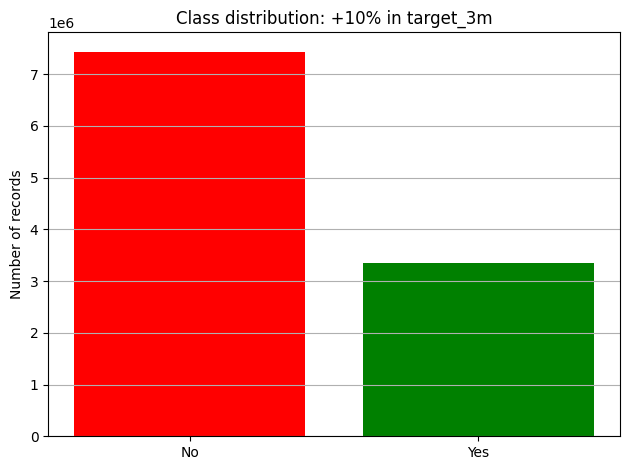

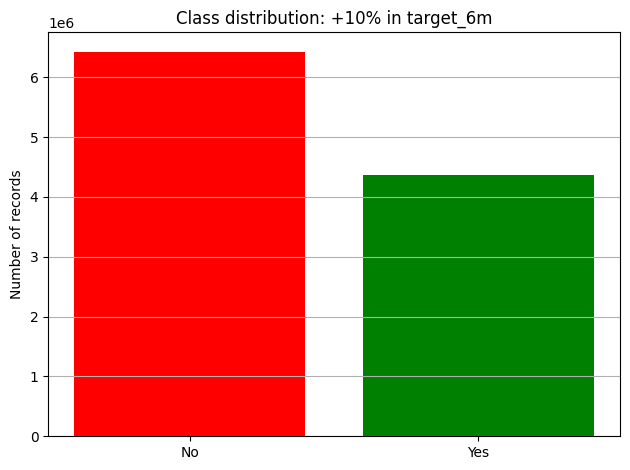

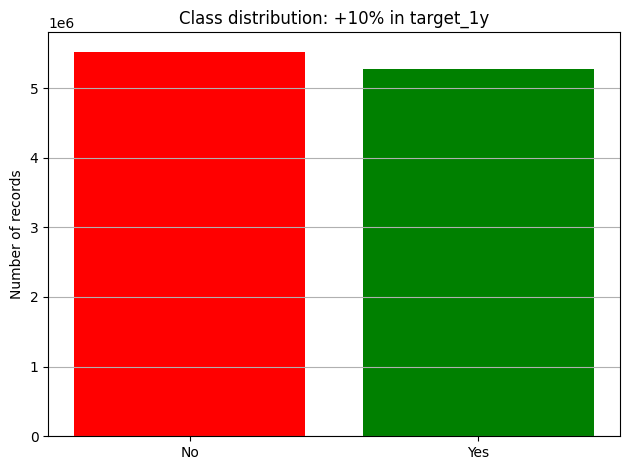

In [32]:
plot_target_distribution(df, "target_3m", "+10%")
plot_target_distribution(df, "target_6m", "+10%")
plot_target_distribution(df, "target_1y", "+10%")

##### 4.3.3 Evolución temporal de una variable para un símbolo

Para terminar de comprobar que nuestros datos son correctos, obtenemos algunos históricos. La forma de las curvas de 3 de las 7 magníficas reflejan perfectamente eventos reales como la subida post-Covid, burbujas, correcciones, etc. Creemos que tenemos un close_v limpio y ajustado a las gráficas reales, lo cual resulta una base sólida para modelar.

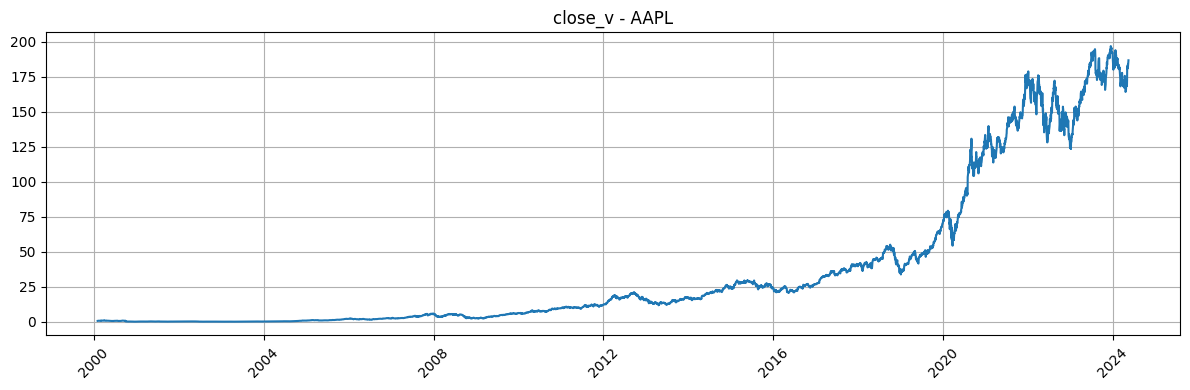

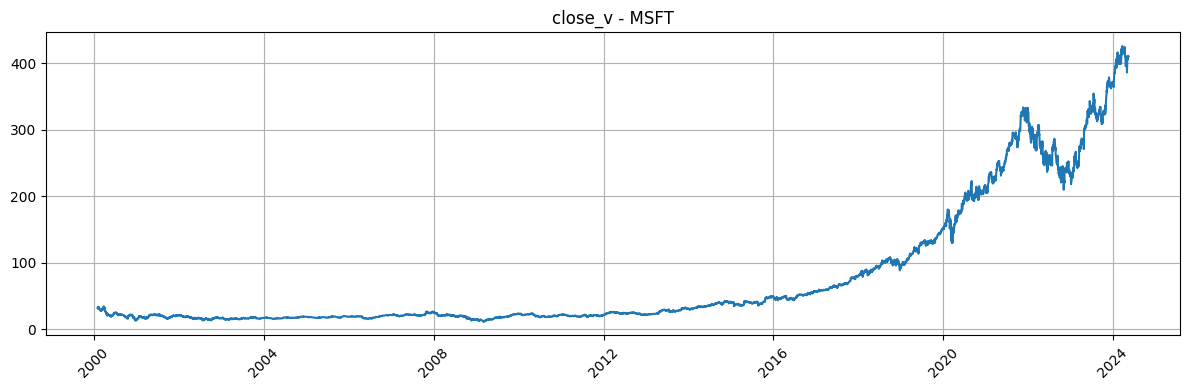

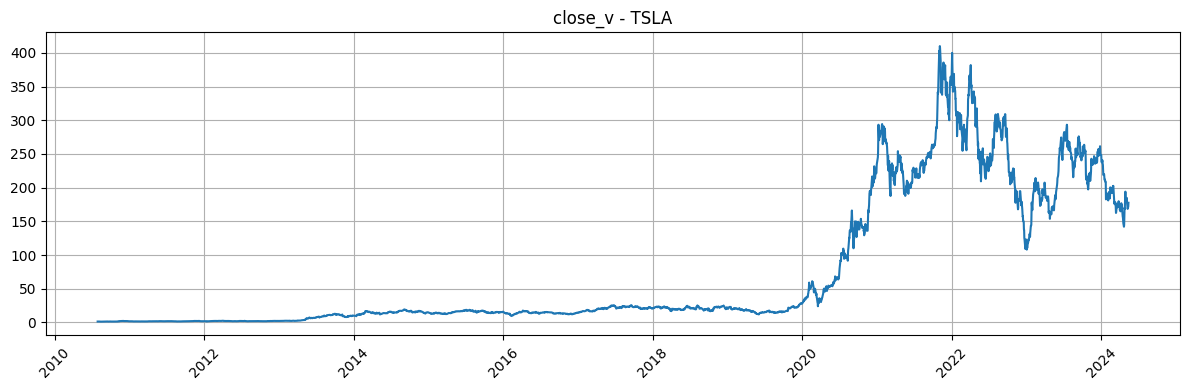

In [33]:
plot_close_price(df, "AAPL")
plot_close_price(df, "MSFT")
plot_close_price(df, "TSLA")

##### 4.3.4 Correlación entre features

El análisis de correlación entre variables permite identificar relaciones lineales entre los distintos indicadores técnicos, financieros y los objetivos de nuestras predicciones.  Su representación mediante heatmaps facilita la visualización de patrones redundantes y orienta la selección de variables relevantes para los modelos. Además, la observación de la correlación entre los indicadores y targets binarios permite realizar una primera evaluación del poder explicativo de cada feature con respecto al comportamiento futuro del activo. 

A continuación dividimos en distintos grupos las variables de nuestro dataset para facilitar su análisis. La correlación se calcula mediante coeficiente de Pearson y se visualiza mediante un Heatmap. Primero calcularemos la correlación intra grupo y, posteriormente, otra sin las variables descartadas.

In [37]:
print(df.columns)

Index(['date', 'symbol', 'open_v', 'high', 'low', 'close_v', 'volume',
       'dividends', 'stock_splits', 'prev_close', 'prev_volume',
       'daily_return', 'close_change_pct', 'intraday_volatility',
       'price_range', 'gap_open', 'log_return', 'volume_change_pct',
       'is_dividend_day', 'is_stock_split', 'sma_5', 'sma_20', 'delta', 'gain',
       'loss', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'rel_volume',
       'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'macd_histogram',
       'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body',
       'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10',
       'var_95', 'ret_next_3m', 'ret_next_6m', 'ret_next_1y', 'target_3m',
       'target_6m', 'target_1y'],
      dtype='object')


In [38]:
# Identification and basic structure
id_cols = ['date', 'symbol']

# Raw price and volume data
price_cols = ['open_v', 'high', 'low', 'close_v', 'volume']

# Corporate actions and event flags
corporate_actions = ['dividends', 'stock_splits', 'is_dividend_day', 'is_stock_split']

# Daily return and percentage change features
return_features = ['prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 
                   'gap_open', 'log_return', 'volume_change_pct']

# Volatility and range-based indicators
volatility_features = ['intraday_volatility', 'price_range', 'true_range', 
                       'tr_1', 'tr_2', 'tr_3', 'atr_14']

# Technical indicators (momentum, moving averages, oscillators)
technical_indicators = ['sma_5', 'sma_20', 'rsi_14', 'bollinger_upper', 'bollinger_lower',
                        'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'macd_histogram',
                        'rel_volume', 'momentum_10', 'roc_10']

# Candlestick structure and patterns
candle_features = ['candle_body', 'upper_wick', 'lower_wick', 'candle_color']

# Forward-looking returns (prediction targets base)
forward_returns = ['ret_next_3m', 'ret_next_6m', 'ret_next_1y']

# Target columns for binary classification
targets = ['target_3m', 'target_6m', 'target_1y']

# Other derived or statistical features
misc_features = ['delta', 'gain', 'loss', 'var_95']


- **Grupo de precios y volumen:**  Se ha iniciado el estudio exploratorio con una representación del bloque de variables básicas de precios y volumen frente a los 3 objetivos de predicción.  Se observa que existe una correlación casi perfecta entre las variables de precios `open_v`, `high`, `low` y `close_v`, lo que confirma la presencia de multicolinealidad. 
El volumen de negociación no representa una correlación significativa, ni con los precios ni con las variables objetivo, lo que indica una baja capacidad predictiva directa. Los targets presentan una ligera correlación entre sí.  Se eliminarán las variables altamente colineales de nuestros modelo, por lo que se descartarán **open_v, high y low**, ya que muestran respectivamente la volatilidad intradía al representar el precio de apertura, precio máximo del día y precio mínimo del día respectivamente.

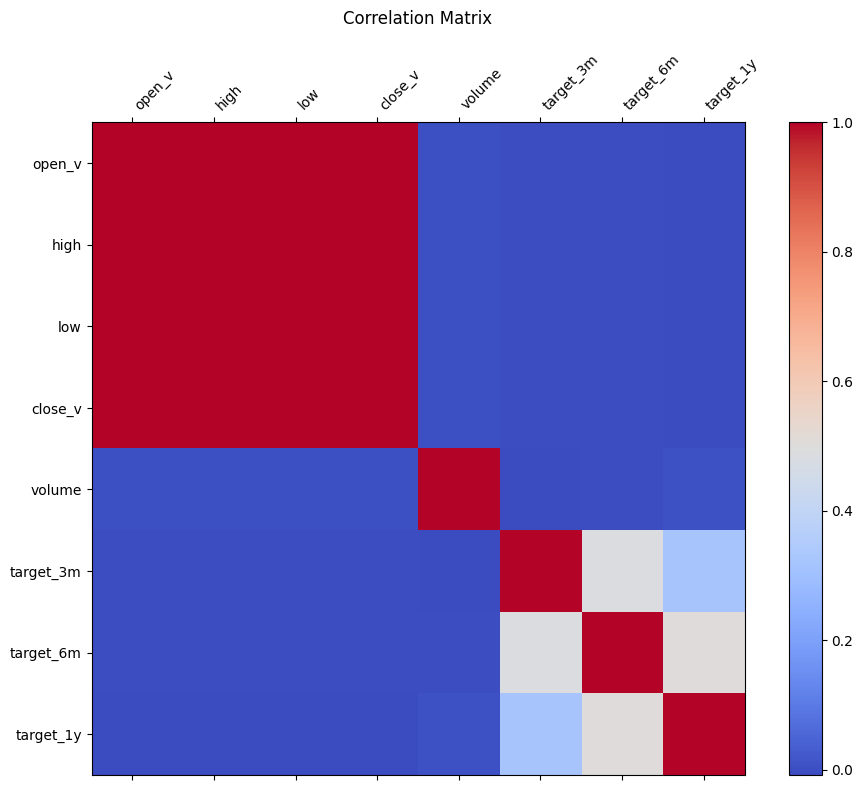

In [39]:
# Raw price and volume data
plot_correlation_heatmap(df, price_cols + targets)

- **Grupo de acciones corporativas y eventos discretos:** Los eventos como dividendos (pagos que la empresa distribuye entre sus accionistas a partir de sus beneficios)  y splits (acciones contables por las que las acciones se multiplican dividiendo proporcionalmente su precio para hacerlas más accesibles) suelen alterar el comportamiento de los inversores y, por tanto, afectar al rendimiento futuro. Existe una correlación moderada entre is_stock_split y stock_split. Entre dividends y is_dividend_day existe una baja correlación, posiblemente porque la mayoría de días is_dividend_day y dividends son casi siempre 0. La relación de estas variables con los targets es de una correlación muy baja. 
Los dividendos y splits no muestran una correlación significativa con la rentabilidad futura de las acciones en los horizontes definidos. 

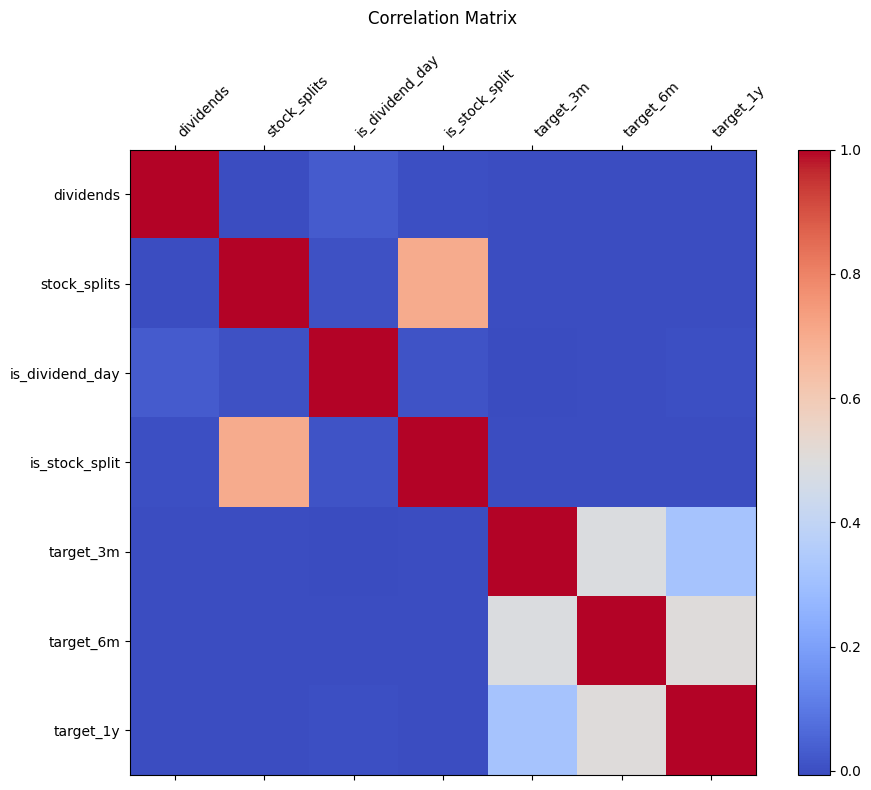

In [40]:
# Corporate actions and event flags
plot_correlation_heatmap(df, corporate_actions + targets)

- **Grupo devariaciones diarias y retornos:**  daily_return, close_change_pct y log_return tienen poca correlación, aunque se calculan en base a las mismas variables. gap_open (mide el salto de apertura con respecto al cierre anterior) y close_change_pct (mide el cambio de cierre respecto al día anterior) están muy correlacionadas. Descartaremos la variable **gap_open**. La correlación de estas variables con los targets es baja.

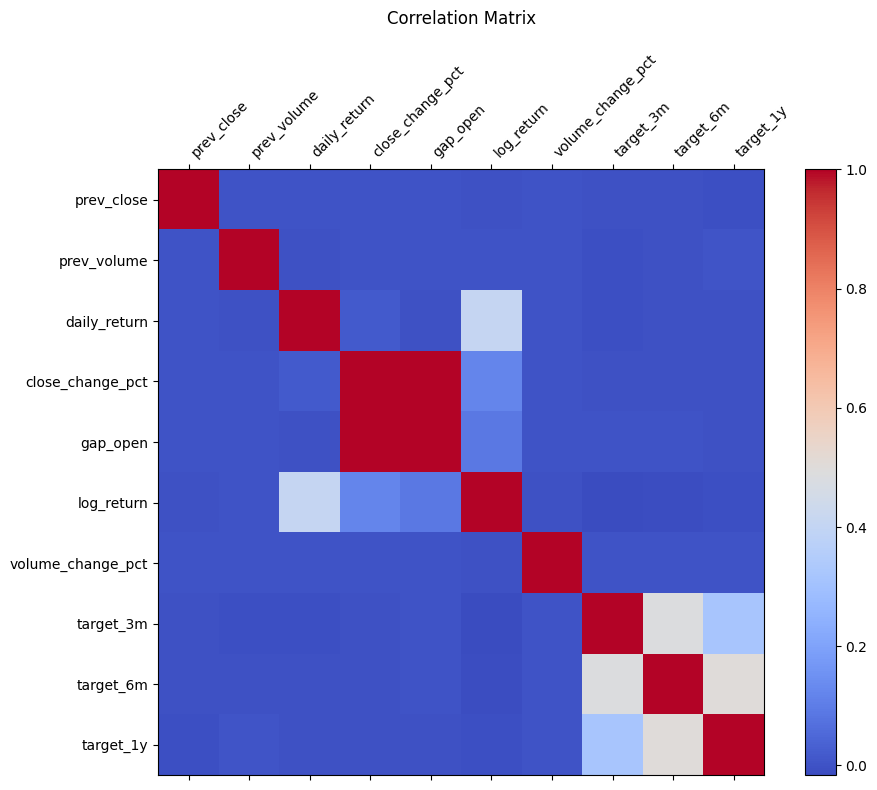

In [41]:
# Daily return and percentage change features
plot_correlation_heatmap(df, return_features + targets)

- **Grupo de variables de volatilidad y rango:** Este grupo incluye variables que miden la amplitud del movimiento diario de precios (price_range, intraday_volatility), así como medias más avanzadas como el true_range, sus componentes (tr_1, tr_2 y tr_3) y el indicador técnico atr_14. Estas métricas son fundamentales para caracterizar la volatilidad de un activo a corto y medio plazo. 

Recordemos el significado de las variables: 
1. **tr_1**: rango del día (diferencia entre máximo y mínimo intradía)
2. **tr_2**: diferencia entre el máximo del día y el cierre anterior (gap alcista)
3. **tr_3**: diferencia entre el mínimo del día y el cierre anterior (gap bajista)
4. **atr_14**: media móvil de true_range durante los últimos 14 días.
5. **price_range**: diferencia entre el precio más alto y más bajo del día.
6. **intraday_volatility**: price_range normalizado respecto al precio de apertura.
7. **true_range**: Medida que detecta gaps entre sesiones. Si no hay un cap significativo entre el cierre anterior y la apertura actual, entonces true_range y price_range suelen ser parecidas. Los gaps (alcistas y bajistas) son aperturas muy por encima o por debajo de mercado.

price_range y true_range miden conceptos similares, pero true_range es más completa al capturar movimientos entre sesiones. Por eso, no siempre están altamente correlacionadas, especialmente si hay muchos gaps de apertura.

Conservaremos solamente true_range, atr_14 e intraday_volatility. Esta limpieza evita redundancia, mejorará la eficiencia de los modelos y posiblemente reducirá el overfitting.


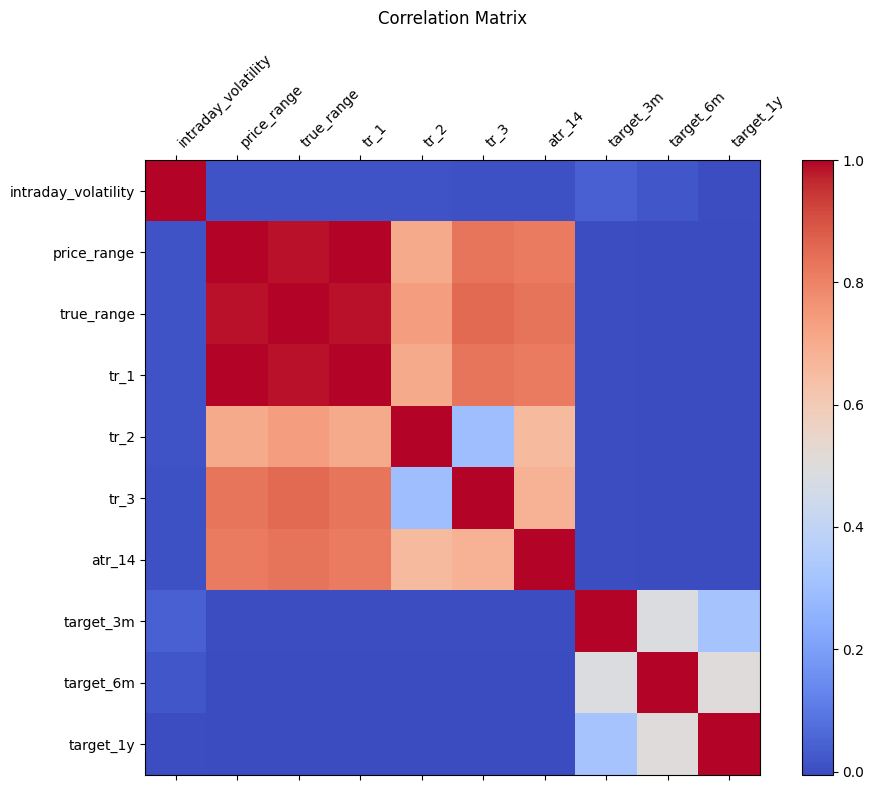

In [42]:
# Volatility and range-based indicators
volatility_features = ['intraday_volatility', 'price_range', 'true_range','tr_1', 'tr_2', 'tr_3', 'atr_14']
plot_correlation_heatmap(df, volatility_features + targets)


- **Grupo de indicadores técnicos:** Utilizados ampliamente en análisis cuantitativo, incluyen:
    - Medias móviles: Medias móviles simples (SMA), exponenciales(EMA), bandas de Bollinger (calculadas a  partir de una media móvil ± 2 desviaciones estándar. Indican niveles de sobrecompra( sobreventa). Todas están muy corelacionadas entre sí, ya que derivan directamente del precio con distintas ventanas de suavizado.
    
    - Indicadores de momentum: Momentum (diferencia entre el cierre actual y el de hace 10 días), roc (Variante porcentual de momentum) y rsi_14 (Relative Strenght Index): Deberían estar relacionadas, pero la correlación de Pearson es sensible a la escala. momentum está en unidades de precio mientras que roc está en proporciones. 
    
    - MACD: macd_signal line es la diferencia entre ema_12 y ema_26. No está fuertemente correlacionada con ellas. macd_signal es la media móvil exponencial a 9 días de la macd_line y se usa para detectar cruces como señales de compra/venta. macd_histogram es la diferencia entre macd_line y macd_signal. Representa la aceleración del momentum. Están correlacionaadas moderadamente. 
    
    - rel_volume: volumen relativo. Compara el volumen actual frente a su media reciente. Se emplea para detectar movimientos con fuerza. Se comporta de forma independiente con las demás. 

    La medida más correlacionada con las targets es el rsi_14.  Este comportamiento podría ser coherente con su naturaleza de oscilador técnico que capta dinámicas de sobrecompra o sobreventa a corto plazo, lo que lo convierte en un buen candidato como variable predictora.

   Eliminaremos sma_5, bollinger_upper, bollinger_lower, ema_12 y  madcd_line


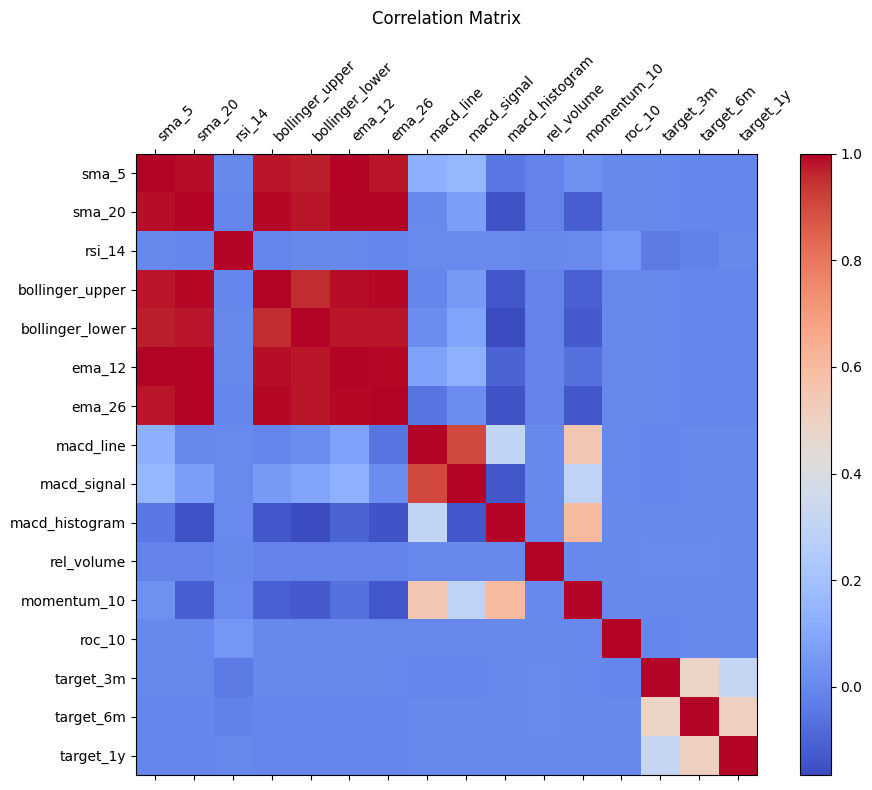

In [43]:

# Technical indicators (momentum, moving averages, oscillators)
technical_indicators = ['sma_5', 'sma_20', 'rsi_14', 'bollinger_upper', 'bollinger_lower','ema_12', 'ema_26', 'macd_line', 'macd_signal', 'macd_histogram','rel_volume', 'momentum_10', 'roc_10']
plot_correlation_heatmap(df, technical_indicators + targets)


- **Grupo de estructura y patrones de velas japonesas:** Este grupo incluye medidas derivadas de la forma de la vela diaria:
    - candle_body (Cuerpo).
    - upper_wick / lower_wick (mechas superior e inferior).
    - candle_color (direción del movimiento, 1 si la vela es alcista y 0 si es bajista).

Tienen correlaciones moderadas entre sí, lo cual tiene sentido porque juntas forman la estructura de la vela.  No eliminaremos  ninguna variable.

/tmp/ipykernel_3347/1619737512.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[columns].corr()


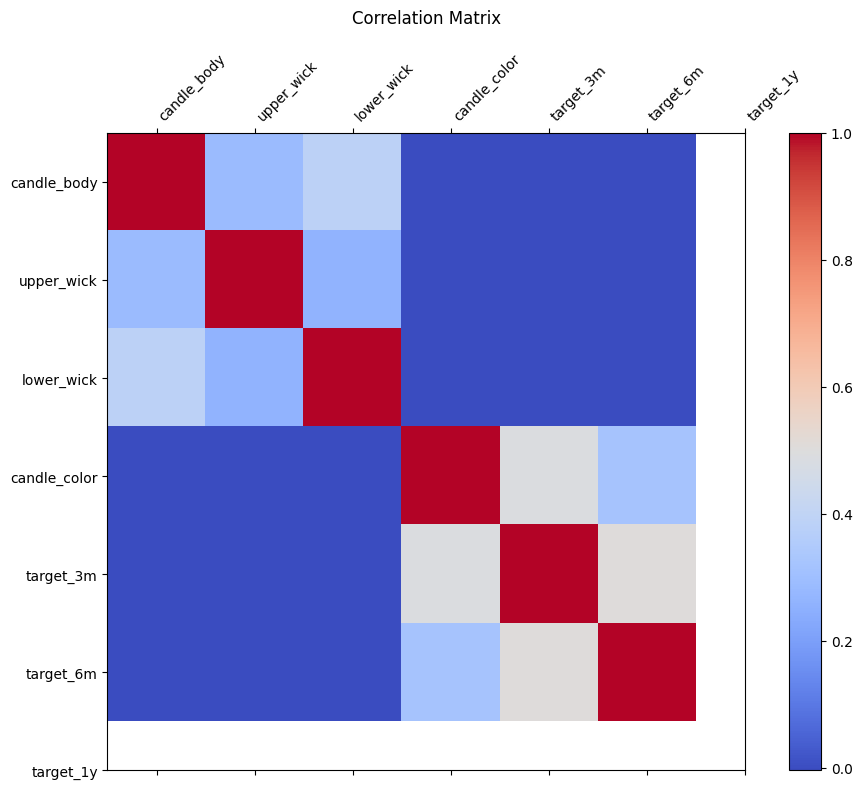

In [45]:
# Candlestick structure and patterns
candle_features = ['candle_body', 'upper_wick', 'lower_wick', 'candle_color']
plot_correlation_heatmap(df, candle_features + targets)

- **Grupo de retornos históricos acumulados:** Existe cierta correlación entre los retornos futuros (ret_next_3m, ret_next_6m, ret_next_1y) y sus respectivos targets. Esto es coherente, ya que los targets binarios se construyen directamente a partir de estos retornos aplicando un umbral del 10%. Los ret_next_* permiten cuantificar la magnitud exacta del rendimiento futuro más allá de la simple clasificación binaria, por lo que se conservarán como referencia en el análisis exploratorio y diagnóstico del comportamiento del modelo.

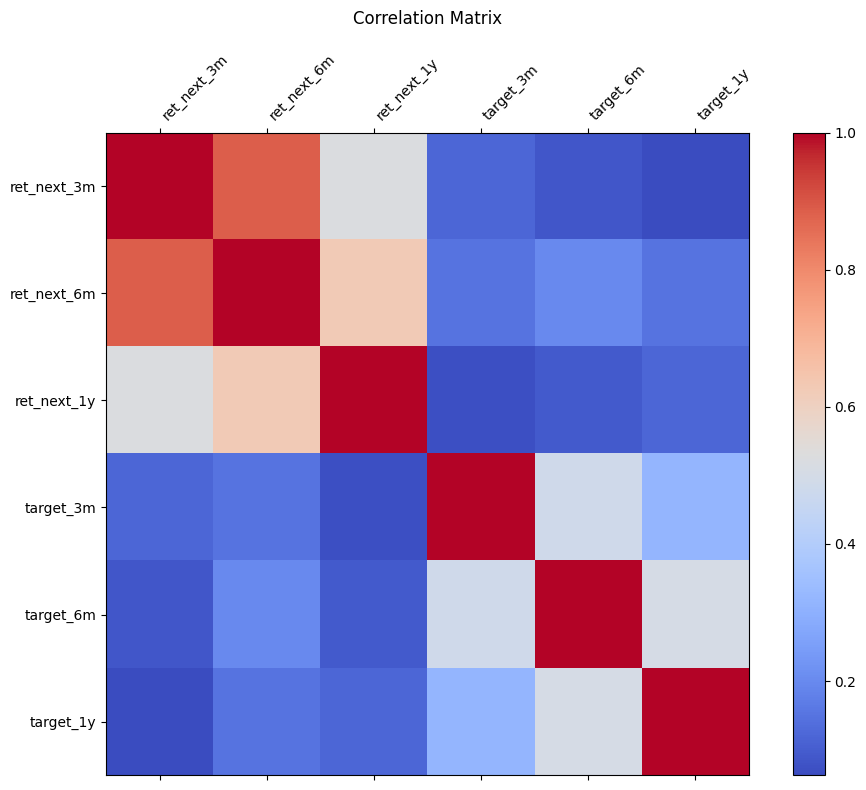

In [46]:
forward_returns = ['ret_next_3m', 'ret_next_6m', 'ret_next_1y']
plot_correlation_heatmap(df, forward_returns + targets)

- **Grupo de variables derivadas o estadísticas personalizadas:** Incluye variables estadísticas simples calculadas a partir de los retornos diarios, como la delta (diferencia entre pérdidas y ganancias), gain, loss y la var_95 (Value at Risk estimado al 95%). Estas variables no corresponden a indicadores técnicos clásicos, pero pueden aportar perspectiva sobre el riesgo y dirección reciente del precio. 
    - gain y loss tienen cierta correlación negativa.
    - gain y delta tienen una correlación moderadamente alta. Si loss es más o menos estable o con poca varianza, delta se mueve principalmente con gain. No obstante, aunque pueda introducir redundancia, mantendremos ambas.

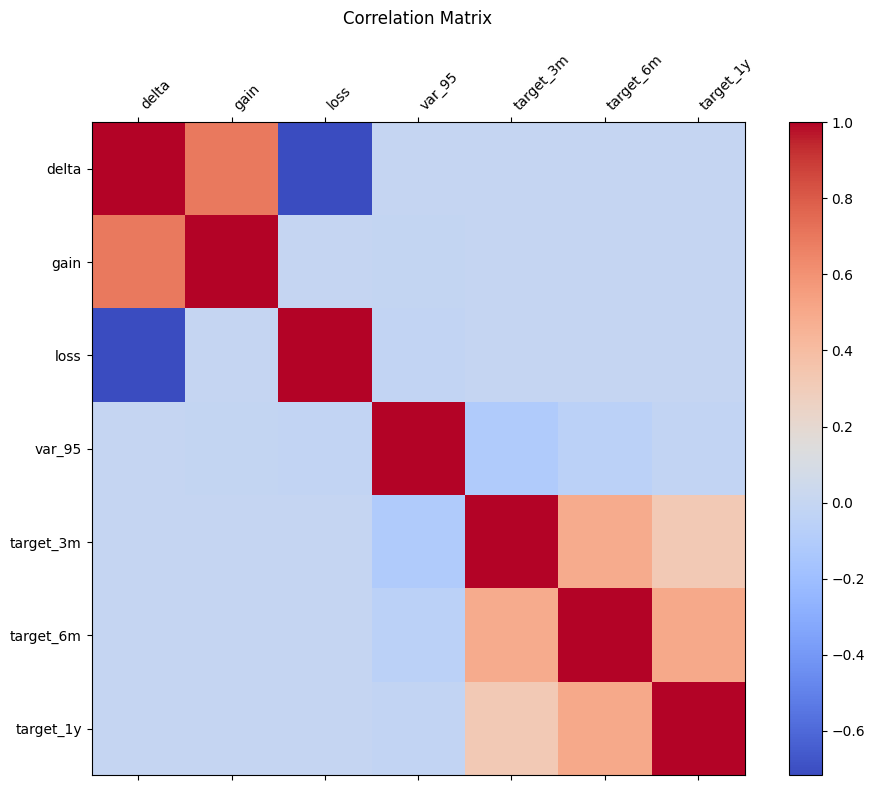

In [48]:
# Other derived or statistical features
misc_features = ['delta', 'gain', 'loss', 'var_95']
plot_correlation_heatmap(df, misc_features + targets)

Vamos entonces a eliminar las siguientes variables: 

In [20]:
columns_to_drop = [
    'capital_gains', 'ret_next_3m', 'ret_next_6m', 'ret_next_1y',"price_lead_3m", "price_lead_6m", "price_lead_1y"]
df = df.drop(columns=columns_to_drop)
print(f"Columns: {df.columns}")

Columns: Index(['date', 'symbol', 'open_v', 'high', 'low', 'close_v', 'volume',
       'dividends', 'stock_splits', 'prev_close', 'prev_volume',
       'daily_return', 'close_change_pct', 'intraday_volatility',
       'price_range', 'gap_open', 'log_return', 'volume_change_pct',
       'is_dividend_day', 'is_stock_split', 'sma_5', 'sma_20', 'delta', 'gain',
       'loss', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'rel_volume',
       'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'macd_histogram',
       'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body',
       'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10',
       'var_95', 'target_3m', 'target_6m', 'target_1y'],
      dtype='object')


/tmp/ipykernel_3305/1619737512.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[columns].corr()


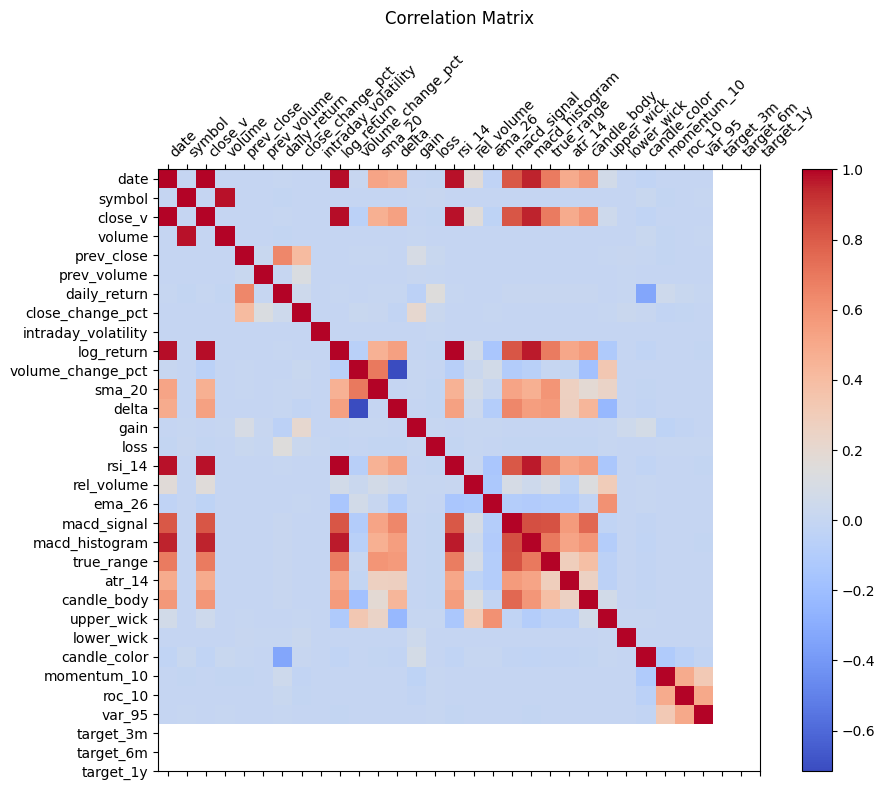

In [27]:
# Final heatmap:

plot_correlation_heatmap(df, df.columns)


In [21]:
df.dtypes

date                   datetime64[ns]
symbol                       category
open_v                        float64
high                          float64
low                           float64
close_v                       float64
volume                        float64
dividends                     float64
stock_splits                  float64
prev_close                    float64
prev_volume                   float64
daily_return                  float64
close_change_pct              float64
intraday_volatility           float64
price_range                   float64
gap_open                      float64
log_return                    float64
volume_change_pct             float64
is_dividend_day               float64
is_stock_split                float64
sma_5                         float64
sma_20                        float64
delta                         float64
gain                          float64
loss                          float64
rsi_14                        float64
bollinger_up

In [22]:
df.shape

(10846547, 49)

##### **4.4 NORMALIZACIÓN DE LOS DATOS**

A continuación normalizaremos los datos, para Naive Bayes y SVM emplearemos Standar Scaler y para LSTM MinMaxScaler. Para tal fin, en el apartado funciones hemos generado la función prepare_data.

- Naive Bayes asume que cada feature sigue una distribución normal. StandarScaler transforma los datos a media 0 y desviación típica 1, lo cual se ajusta a esta asunción.

- SVM usa distancias en un espacio de características. Si una variable tiene una escala mucho mayor que otra, dominará la función de decisión.  StandarScaler equilibria las escalas.

- LSTM / Redes neuronales suelen funcionar mejor con datos en rangos [0,1] que [-1,1]. Las activaciones (ReLu, tanh, sigmoid) están diseñadas para trabajar en estos rangos. 




In [23]:
top_symbols = (
    df.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20) 
    .index
)
df_20_symbols = df[df["symbol"].isin(top_symbols)].copy()

top_symbols = (
    df.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100) 
    .index
)
df_100_symbols = df[df["symbol"].isin(top_symbols)].copy()

top_symbols = (
    df.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(500) 
    .index
)
df_500_symbols = df[df["symbol"].isin(top_symbols)].copy()

In [24]:
print(df_20_symbols.dtypes)
print(df_20_symbols.shape)


date                   datetime64[ns]
symbol                       category
open_v                        float64
high                          float64
low                           float64
close_v                       float64
volume                        float64
dividends                     float64
stock_splits                  float64
prev_close                    float64
prev_volume                   float64
daily_return                  float64
close_change_pct              float64
intraday_volatility           float64
price_range                   float64
gap_open                      float64
log_return                    float64
volume_change_pct             float64
is_dividend_day               float64
is_stock_split                float64
sma_5                         float64
sma_20                        float64
delta                         float64
gain                          float64
loss                          float64
rsi_14                        float64
bollinger_up

#### **5. TRAINING**

##### **5.1 NAIVE BAYES**

Como primer modelo de clasificación se ha empleado Naive Bayes con la variante GaussianNB. Se trata de un algoritmo rápido y eficiente, incluso con conjuntos de datos de gran tamaño como el que se emplea en este trabajo.  Esto permite realizar una evaluación inicial del rendimiento sin incurrir en costes computacionales elevados. 

Además, este algoritmo no requiere un alto número de hiperparámetros, lo que simplifica su entrenamiento y reduce el riesgo de sobreajuste.  En este trabajo se emplea GridSearchCV ara ajustar el hiperparámetro `var_smoothing`, que controla la estabilidad del modelo frente a variables con varianza baja. Esta búsqueda permite mejorar el rendimiento sin apenas penalización computacional.

Una limitación importante de GaussianNB es que no admite valores nulos en los datos. Pese a la limpieza de los mismos en puntos anteriores, en las siguientes celdas podemos ver como algunas características relativas a las rentabilidades históricas acumuladas todavía presentan nulos. Esto se debe mayoritariamente a que hay empresas de más reciente creación que el intervalo calculado.  Por lo tanto, se debe realizar una imputación por media a las columnas con datos faltantes. Esta estrategia permite conservar el mayor número de observaciones sin introducir sesgos graves.

A continuación, se define `X` e `y`, para aplicar un `train_split_test` sin shuffle para evitar romper la secuencia cronológica. Si no lo hiciésemos, estaríamos entrenando con datos que ocurren después de los que se usan para test, lo que iría en contra de la estructura temporal de los mercados financieros. En estos datos importa el orden temporal: Los precios de hoy dependen de los de ayer. 

Finalmente, es necesario tener en cuenta que las variables están estandarizadas, ya que Naive Bayes asume distribución normal de sus variables. Las variables categóricas deben estar codificadas numéricamente, como es el caso de 
`candle_color`.

Existen otras variantes del algoritmo como MultinomialNB (orientada a datos discretos como recuentos) y BernouilliNB (para variables binarias). No se han considerado en este trabajo porque el conjunto de datos está compuesto por variables continuas. 


##### 5.1.1 Preprocesado de los datos

##### 5.1.2 Entrenamiento del modelo, predicciones y evaluación

In [25]:
def train_naive_bayes(
    df: pd.DataFrame,
    features: List[str],
    target_col: str,
) -> Tuple[GaussianNB, pd.Series, pd.Series,pd.Series]:
    """
    Trains a Naive Bayes classifier with GridSearchCV and returns predictions and evaluation metrics.

    Args:
       - df (pd.DataFrame): Preprocessed DataFrame with features and target.
       - target_col (str): Name of the target column to predict.

    Returns:
        model (GaussianNB): Trained Naive Bayes model.
        y_test (pd.Series): True target values for test set.
        y_pred (pd.Series): Predicted class labels.
        metrics (dict): Dictionary with accuracy, f1, roc_auc, and confusion matrix.
    """
    X = df[features]
    y = df[target_col]

    # Impute missing values
    X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=features)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Grid search
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
    grid = GridSearchCV(GaussianNB(), param_grid, scoring='f1', cv=3)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_

    # Prediction
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return model, y_test, y_pred,y_prob

In [26]:
def run_naive_bayes_pipeline(df, target_col, drop_cols=['date', 'symbol'], scaler_type='standard', k_best=30):
    """
    Runs the complete pipeline for Naive Bayes classification:
    - Data preparation (dropping columns, encoding, scaling, feature selection)
    - Model training with GridSearchCV
    - Prediction and evaluation

    Args:
        df (pd.DataFrame): Input dataframe including features and targets.
        target_col (str): Target variable to predict.
        drop_cols (list): Columns to drop before processing.
        scaler_type (str): Scaler type, either 'standard' or 'minmax'.
        k_best (int): Number of top features to select.

    Returns:
        dict: Dictionary containing model, scaler, selected features, and evaluation metrics.
    """
    # Prepare data
    df_processed, scaler, selected_features = prepare_data(
        df,
        target=target_col,
        scaler_type=scaler_type,
        drop_cols=drop_cols,
        k_best=k_best
    )

    # Define feature columns excluding the target
    features = [col for col in df_processed.columns if col != target_col]

    # Train the Naive Bayes model and get predictions
    model, y_test, y_pred, y_prob = train_naive_bayes(df_processed, features, target_col)

    # Evaluate the model performance
    acc, f1, roc, cm, precision, recall = model_evaluation(y_test, y_pred, y_prob)

    # Return results in a dictionary
    return {
        'model': model,
        'scaler': scaler,
        'selected_features': selected_features,
        'accuracy': acc,
        'f1_score': f1,
        'roc_auc': roc,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall
    }


Accuracy: 0.6915
F1 Score: 0.0829
ROC AUC: 0.5283
Confusion Matrix:
 [[17002   696]
 [ 7046   350]]
Precision: 0.3346
Recall: 0.0473


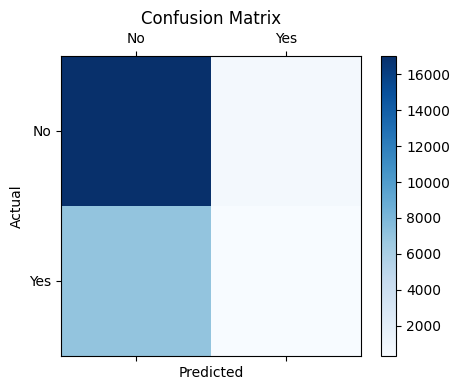

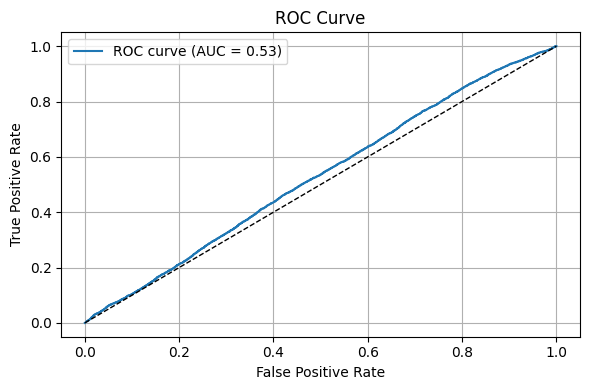

Accuracy: 0.6169
F1 Score: 0.0443
ROC AUC: 0.5255
Confusion Matrix:
 [[15258   130]
 [ 9483   223]]
Precision: 0.6317
Recall: 0.0230


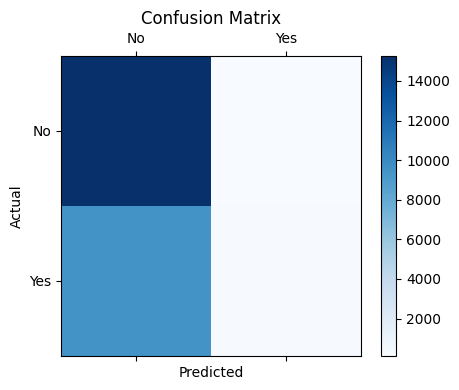

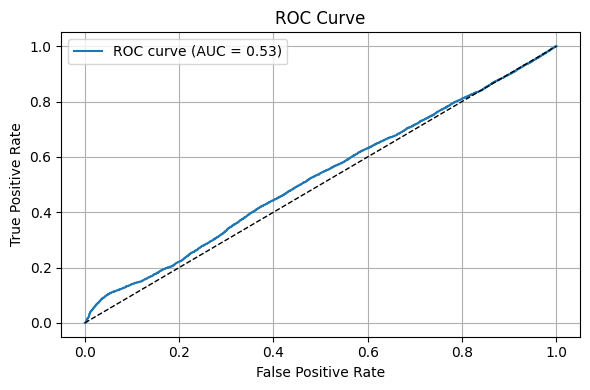

Accuracy: 0.5194
F1 Score: 0.0640
ROC AUC: 0.4849
Confusion Matrix:
 [[12622   270]
 [11790   412]]
Precision: 0.6041
Recall: 0.0338


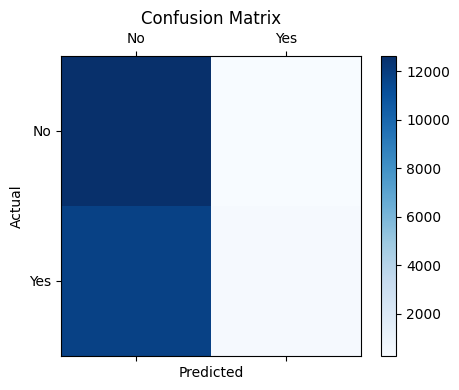

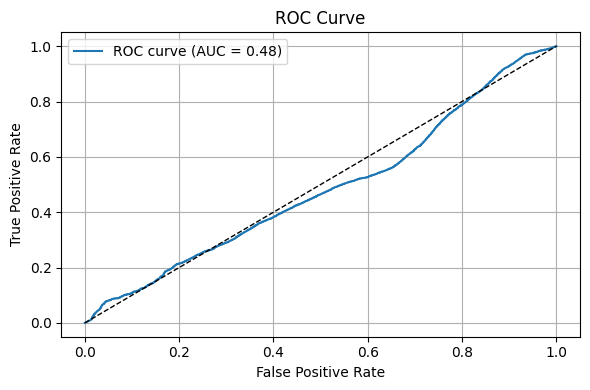

In [27]:
results_3m_20 = run_naive_bayes_pipeline(df_20_symbols, 'target_3m')
results_6m_20 = run_naive_bayes_pipeline(df_20_symbols, 'target_6m')
results_1y_20 = run_naive_bayes_pipeline(df_20_symbols, 'target_1y')

Accuracy: 0.3633
F1 Score: 0.4204
ROC AUC: 0.5592
Confusion Matrix:
 [[16488 74649]
 [ 4671 28771]]
Precision: 0.2782
Recall: 0.8603


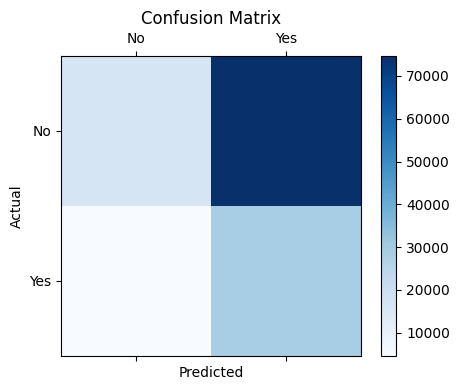

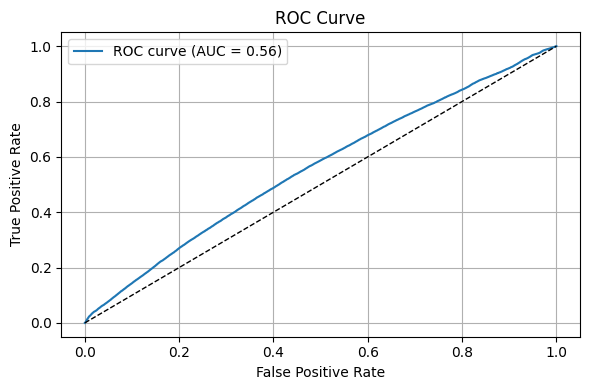

Accuracy: 0.3976
F1 Score: 0.5197
ROC AUC: 0.5371
Confusion Matrix:
 [[ 8940 70701]
 [ 4341 40597]]
Precision: 0.3648
Recall: 0.9034


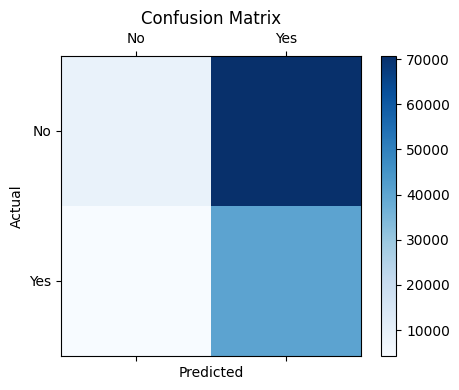

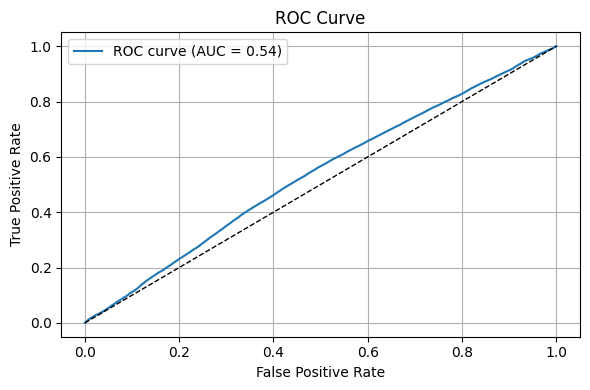

Accuracy: 0.4609
F1 Score: 0.5941
ROC AUC: 0.5035
Confusion Matrix:
 [[ 8276 61599]
 [ 5559 49145]]
Precision: 0.4438
Recall: 0.8984


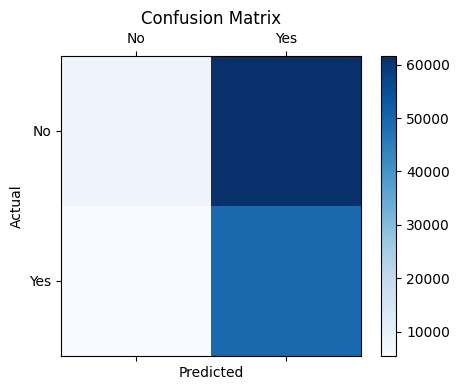

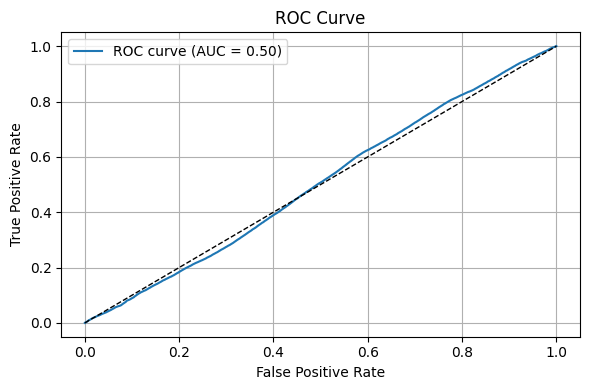

In [28]:
results_3m_100 = run_naive_bayes_pipeline(df_100_symbols, 'target_3m')
results_6m_100 = run_naive_bayes_pipeline(df_100_symbols, 'target_6m')
results_1y_100 = run_naive_bayes_pipeline(df_100_symbols, 'target_1y')

Accuracy: 0.3290
F1 Score: 0.4814
ROC AUC: 0.5529
Confusion Matrix:
 [[ 10873 409356]
 [  3644 191654]]
Precision: 0.3189
Recall: 0.9813


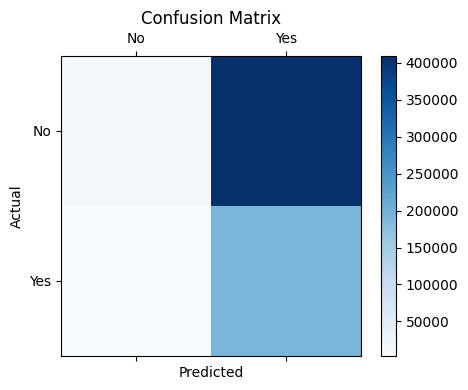

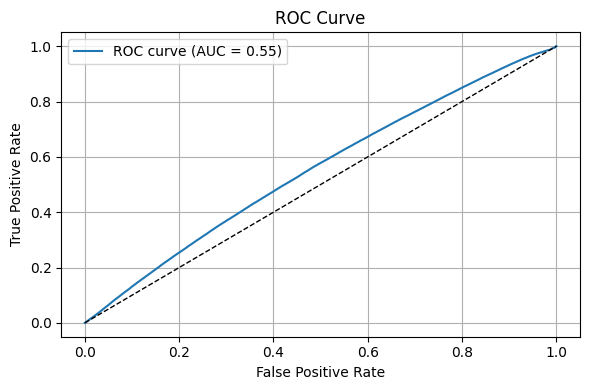

Accuracy: 0.4256
F1 Score: 0.5934
ROC AUC: 0.5197
Confusion Matrix:
 [[  4043 351329]
 [  2217 257938]]
Precision: 0.4234
Recall: 0.9915


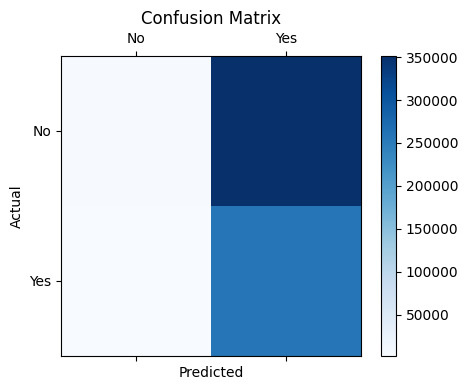

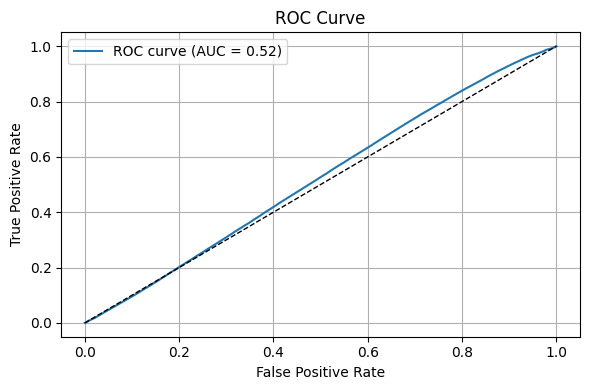

Accuracy: 0.5314
F1 Score: 0.6917
ROC AUC: 0.4943
Confusion Matrix:
 [[  3585 286402]
 [  2009 323531]]
Precision: 0.5304
Recall: 0.9938


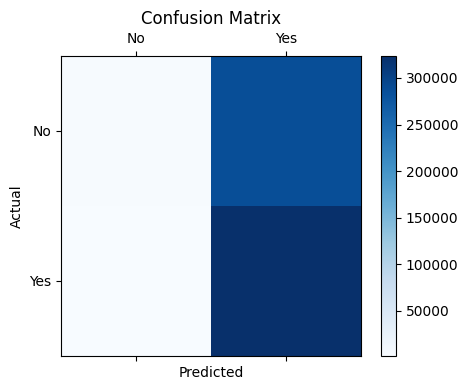

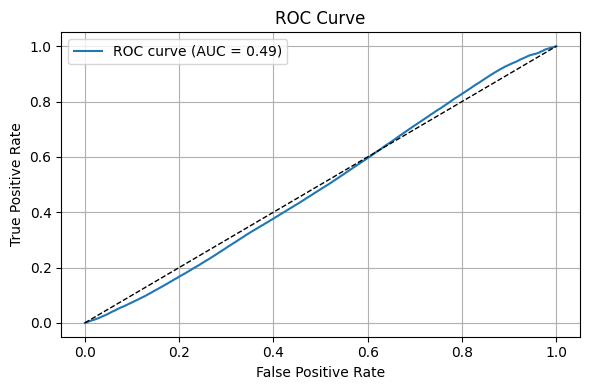

In [29]:
results_3m_500 = run_naive_bayes_pipeline(df_500_symbols, 'target_3m')
results_6m_500 = run_naive_bayes_pipeline(df_500_symbols, 'target_6m')
results_1y_500 = run_naive_bayes_pipeline(df_500_symbols, 'target_1y')

In [30]:
def print_all_results(results_dict):
    for label, results in results_dict.items():
        print(f"--- Results for {label} ---")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"F1 Score: {results['f1_score']:.4f}")
        print(f"ROC AUC: {results['roc_auc']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall: {results['recall']:.4f}")
        print("Confusion Matrix:")
        print(results['confusion_matrix'])
        print("\n")

all_results = {
    "Naive Bayes 3m 20 symbols": results_3m_20,
    "Naive Bayes 6m 20 symbols": results_6m_20,
    "Naive Bayes 1y 20 symbols": results_1y_20,
    "Naive Bayes 3m 100 symbols": results_3m_100,
    "Naive Bayes 6m 100 symbols": results_6m_100,
    "Naive Bayes 1y 100 symbols": results_1y_100,
    "Naive Bayes 3m 500 symbols": results_3m_500,
    "Naive Bayes 6m 500 symbols": results_6m_500,
    "Naive Bayes 1y 500 symbols": results_1y_500,
}

print_all_results(all_results)


--- Results for Naive Bayes 3m 20 symbols ---
Accuracy: 0.6915
F1 Score: 0.0829
ROC AUC: 0.5283
Precision: 0.3346
Recall: 0.0473
Confusion Matrix:
[[17002   696]
 [ 7046   350]]


--- Results for Naive Bayes 6m 20 symbols ---
Accuracy: 0.6169
F1 Score: 0.0443
ROC AUC: 0.5255
Precision: 0.6317
Recall: 0.0230
Confusion Matrix:
[[15258   130]
 [ 9483   223]]


--- Results for Naive Bayes 1y 20 symbols ---
Accuracy: 0.5194
F1 Score: 0.0640
ROC AUC: 0.4849
Precision: 0.6041
Recall: 0.0338
Confusion Matrix:
[[12622   270]
 [11790   412]]


--- Results for Naive Bayes 3m 100 symbols ---
Accuracy: 0.3633
F1 Score: 0.4204
ROC AUC: 0.5592
Precision: 0.2782
Recall: 0.8603
Confusion Matrix:
[[16488 74649]
 [ 4671 28771]]


--- Results for Naive Bayes 6m 100 symbols ---
Accuracy: 0.3976
F1 Score: 0.5197
ROC AUC: 0.5371
Precision: 0.3648
Recall: 0.9034
Confusion Matrix:
[[ 8940 70701]
 [ 4341 40597]]


--- Results for Naive Bayes 1y 100 symbols ---
Accuracy: 0.4609
F1 Score: 0.5941
ROC AUC: 0.5035
P

       Symbols Horizon  Recall  Precision      F1  ROC_AUC
0   20 symbols      3m  0.0473     0.3346  0.0829   0.5283
1   20 symbols      6m  0.0230     0.6317  0.0443   0.5255
2   20 symbols      1y  0.0338     0.6041  0.0640   0.4849
3  100 symbols      3m  0.8603     0.2782  0.4204   0.5592
4  100 symbols      6m  0.9034     0.3648  0.5197   0.5371
5  100 symbols      1y  0.8984     0.4438  0.5941   0.5035
6  500 symbols      3m  0.9813     0.3189  0.4814   0.5529
7  500 symbols      6m  0.9915     0.4234  0.5934   0.5197
8  500 symbols      1y  0.9938     0.5304  0.6917   0.4943


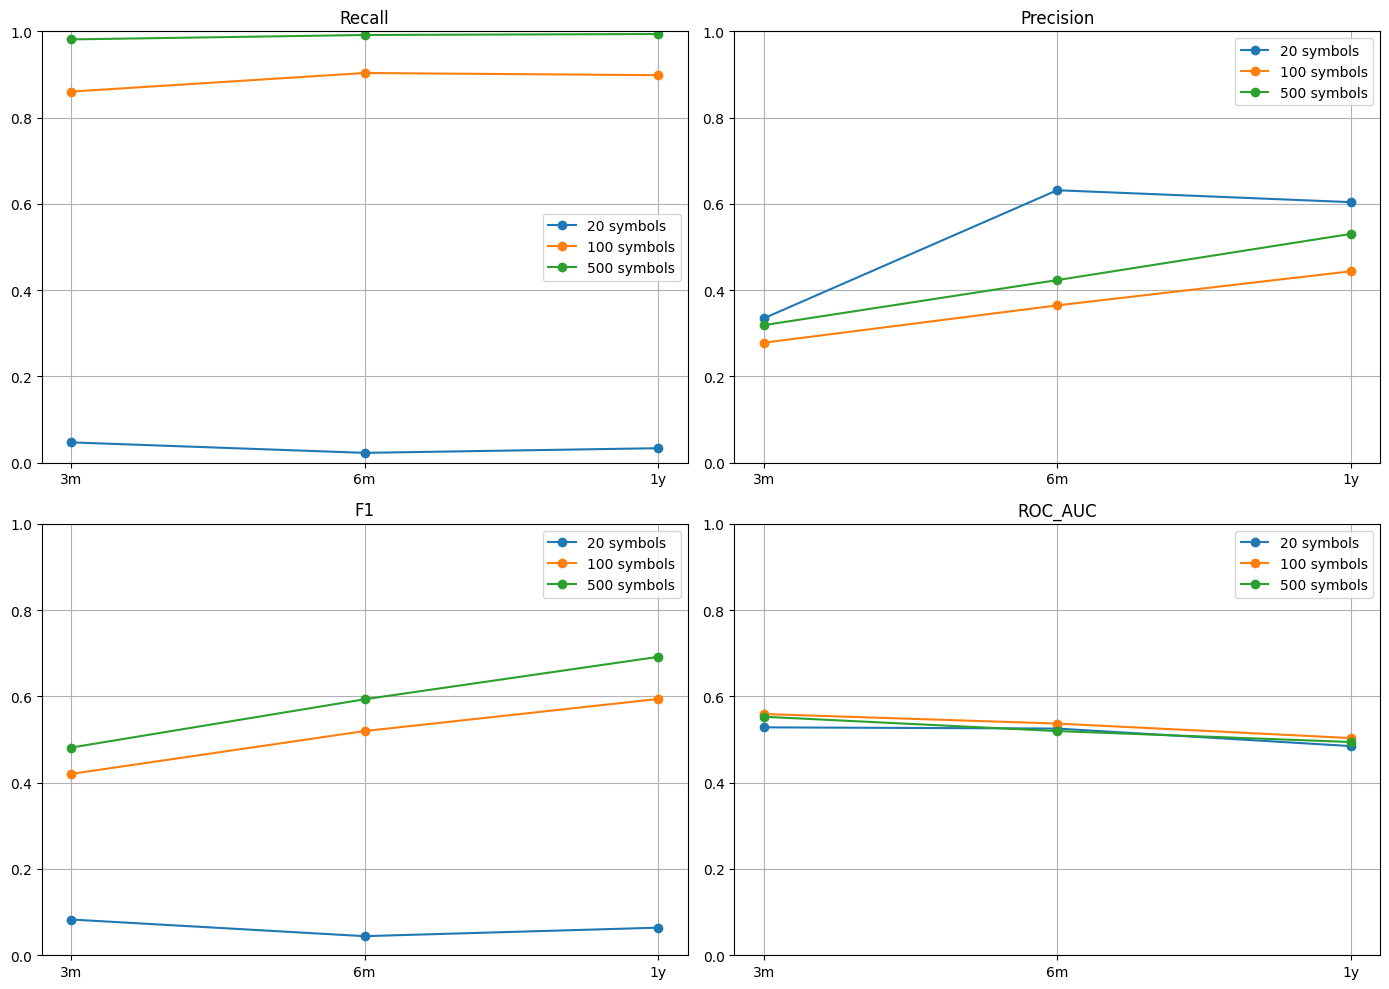

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

data = [
    ['20 symbols', '3m', 0.0473, 0.3346, 0.0829, 0.5283],
    ['20 symbols', '6m', 0.0230, 0.6317, 0.0443, 0.5255],
    ['20 symbols', '1y', 0.0338, 0.6041, 0.0640, 0.4849],
    ['100 symbols', '3m', 0.8603, 0.2782, 0.4204, 0.5592],
    ['100 symbols', '6m', 0.9034, 0.3648, 0.5197, 0.5371],
    ['100 symbols', '1y', 0.8984, 0.4438, 0.5941, 0.5035],
    ['500 symbols', '3m', 0.9813, 0.3189, 0.4814, 0.5529],
    ['500 symbols', '6m', 0.9915, 0.4234, 0.5934, 0.5197],
    ['500 symbols', '1y', 0.9938, 0.5304, 0.6917, 0.4943],
]

df_summary = pd.DataFrame(data, columns=['Symbols', 'Horizon', 'Recall', 'Precision', 'F1', 'ROC_AUC'])

# Mostrar tabla
print(df_summary)

# Gráfico comparativo
fig, axs = plt.subplots(2, 2, figsize=(14,10))

metrics = ['Recall', 'Precision', 'F1', 'ROC_AUC']
for ax, metric in zip(axs.flatten(), metrics):
    for symbol_count in df_summary['Symbols'].unique():
        subset = df_summary[df_summary['Symbols'] == symbol_count]
        ax.plot(subset['Horizon'], subset[metric], marker='o', label=symbol_count)
    ax.set_title(metric)
    ax.set_ylim(0,1)
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()


##### **5.2 SUPPORT VECTOR MACHINES (SVM)**

Support Vector Machines (SVM) es un algoritmo supervisado de clasificación que busca encontrar el hiperplano óptimo que separa las clases en el espacio de características. Su objetivo es maximizar el margen entre las clases, es decir, la distancia entre el hiperplano y los puntos más cercanos (los support vectors).

A diferencia de Naiva Bayes, no asume ninguna distribución de los datos. Puede capturar relaciones no lineales entre variables usando kernels (por defecto, RBF).

Es eficaz en espacios de alta dimensión, como ocurre con indicadores financieros y técnicos; y permite tratar el desbalanceo de clases usando el parámetro `class_weight='balanced'`. 

Es un algoritmo robusto ante ruido moderado y puede generalizar bien en problemas con solapamiento entre clases.

A continuación se resumen algunos de los parámetros más importantes :

- C: Controla el trade-off entre el margen ancho y errores de clasificación. Un C bajo permite un margen más amplio (mayor tolerancia al error).

- gamma: Controla el radio de influencia de cada punto de entrenamiento. Es clave cuando se emplea `kernel='rbf'` (radial basis function), que es el más usado para problemas no lineales.  Valores muy bajos pueden producir underfitting (fronteras muy suaves), mientras que valores muy altos pueden producir overfitting (fronteras muy ajustadas). Por defecto se recomienda 'scale' (Automático: 1 / (n_features * X.var())), pero también se probará 'auto' (1/n_features y menos sensible a la varianza). También es posible configurar valores numéricos. 

- class_weight: Muy útil en problemas desbalanceados. 'balanced' ajusta los pesos automáticamente.

- kernel: Transforma el espacio original de las varaibles en un espacio de mayor dimensión, donde es más fácil encontrar un hiperplano que separe linealmente las clases. Existen distintos tipos de kernels:
    - `linear`: No transforma los datos. Se emplea si hay separación lineal o muchas features.
    - `rbf`: Usa funciones gaussianas para proyectar. Ideal para datos no lineales como los nuestros.
    - `poly`: Aplica una transformación polinómica a los datos. Para casos con relaciones cuadáticas o cúbicas. 
    - `sigmoid`: Similar a neuronas (tangente hiperbólica). Es menos robusto y poco usado. 

    Como estamos entrenando millones de filas, usaremos rbf y linear, pues no sabemos si hay una separación no lineal de los datos.  


##### 5.2.1 Entrenamiento del modelo base. predicciones y evaluación

Para poder probar SVM, necesitamos reducir radicalmente el tamaño del dataset. SVM no escala bien con millones de muestras por su complejidad computacional. 

In [32]:
def train_svm_fast(
    df: pd.DataFrame,
    features: List[str],
    target_col: str,
) -> Tuple[SVC, pd.Series, pd.Series, pd.Series]:
    """
    Trains a basic SVM classifier without GridSearch and returns predictions and probabilities.

    Args:
        df (pd.DataFrame): Preprocessed DataFrame with features and target.
        features (List[str]): List of feature column names.
        target_col (str): Name of the target column to predict.

    Returns:
        model (SVC): Trained SVM model.
        y_test (pd.Series): True test labels.
        y_pred (pd.Series): Predicted labels.
        y_prob (pd.Series): Predicted probabilities for class 1.
    """

    X = df[features]
    y = df[target_col]

    print("Imputing missing values...")
    # Impute missing values
    X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=features)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train SVM with basic configuration
    model = SVC(kernel='linear', C=1, class_weight='balanced', probability=True)

    model.fit(X_train, y_train)
    print("model fit")
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print()

    return model, y_test, y_pred, y_prob


In [33]:
def run_svm_fast_pipeline(
    df, 
    target_col, 
    drop_cols=['date', 'symbol'], 
    scaler_type='standard', 
    k_best=30
):
    """
    Runs the complete pipeline for fast SVM classification:
    - Data preparation (dropping columns, encoding, scaling, feature selection)
    - Model training with fixed parameters (no grid search)
    - Prediction and evaluation

    Args:
        df (pd.DataFrame): Input dataframe including features and targets.
        target_col (str): Target variable to predict.
        drop_cols (list): Columns to drop before processing.
        scaler_type (str): Scaler type, either 'standard' or 'minmax'.
        k_best (int): Number of top features to select.

    Returns:
        dict: Dictionary containing model, scaler, selected features, and evaluation metrics.
    """
    # Prepare data
    df_processed, scaler, selected_features = prepare_data(
        df,
        target=target_col,
        scaler_type=scaler_type,
        drop_cols=drop_cols,
        k_best=k_best
    )

    # Define feature columns excluding the target
    features = [col for col in df_processed.columns if col != target_col]

    # Train the SVM model and get predictions
    model, y_test, y_pred, y_prob = train_svm_fast(df_processed, features, target_col)

    # Evaluate the model performance
    acc, f1, roc, cm, precision, recall = model_evaluation(y_test, y_pred, y_prob)

    # Return results in a dictionary
    return {
        'model': model,
        'scaler': scaler,
        'selected_features': selected_features,
        'accuracy': acc,
        'f1_score': f1,
        'roc_auc': roc,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall
    }


Imputing missing values...
model fit

Accuracy: 0.6092
F1 Score: 0.2690
ROC AUC: 0.5274
Confusion Matrix:
 [[13484  4214]
 [ 5592  1804]]
Precision: 0.2998
Recall: 0.2439


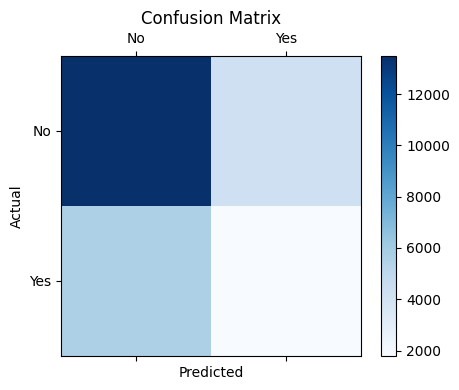

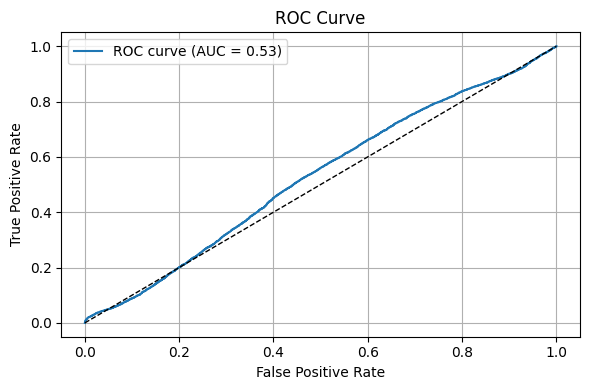

In [35]:
results_svm_3m = run_svm_fast_pipeline(df_20_symbols, 'target_3m')


Imputing missing values...
model fit

Accuracy: 0.5210
F1 Score: 0.3924
ROC AUC: 0.4899
Confusion Matrix:
 [[9193 6195]
 [5825 3881]]
Precision: 0.3852
Recall: 0.3999


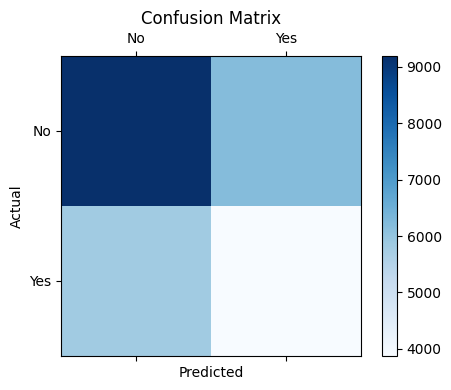

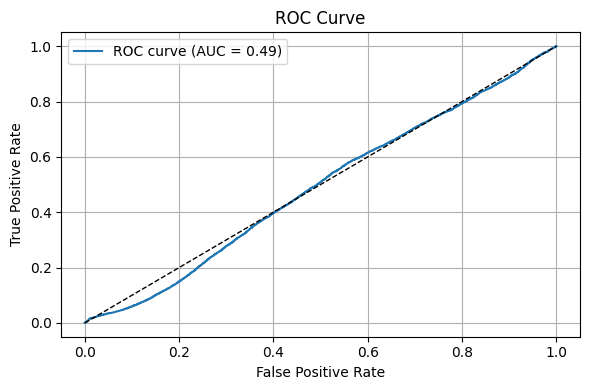

In [36]:
results_svm_6m = run_svm_fast_pipeline(df_20_symbols, 'target_6m')


Imputing missing values...
model fit

Accuracy: 0.4549
F1 Score: 0.5672
ROC AUC: 0.3561
Confusion Matrix:
 [[ 2452 10440]
 [ 3238  8964]]
Precision: 0.4620
Recall: 0.7346


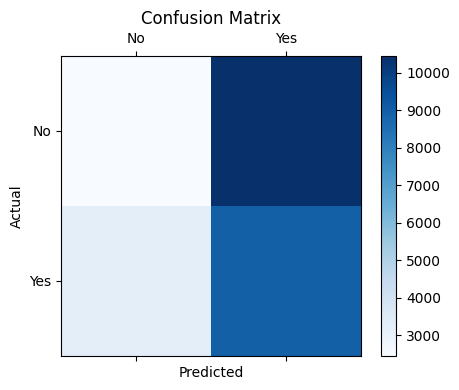

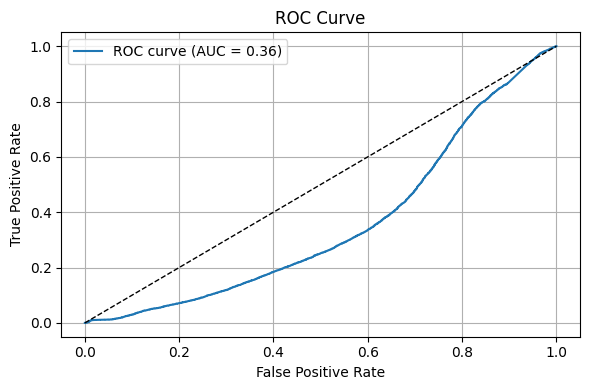

In [37]:
results_svm_1y = run_svm_fast_pipeline(df_20_symbols, 'target_1y')